In [53]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, pacf, acf
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
import keras
import tensorflow as tf

register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller

# OPTIVER - Trading At The Close

In [this competition](https://www.kaggle.com/competitions/optiver-trading-at-the-close), you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunities. Kagglers are challenged to predict the short term price movements during the 10 minute auction period. 

To help you hit the ground running, we have provided [this tutorial notebook](https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction/notebook) that will walk you through the financial concepts and data you will be utilizing to design your model.

In [5]:
df = pd.read_csv(r"data\train.csv", sep = ',')
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [6]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   stock_id                 5237980 non-null  int64  
 1   date_id                  5237980 non-null  int64  
 2   seconds_in_bucket        5237980 non-null  int64  
 3   imbalance_size           5237760 non-null  float64
 4   imbalance_buy_sell_flag  5237980 non-null  int64  
 5   reference_price          5237760 non-null  float64
 6   matched_size             5237760 non-null  float64
 7   far_price                2343638 non-null  float64
 8   near_price               2380800 non-null  float64
 9   bid_price                5237760 non-null  float64
 10  bid_size                 5237980 non-null  float64
 11  ask_price                5237760 non-null  float64
 12  ask_size                 5237980 non-null  float64
 13  wap                      5237760 non-null 

- **stock_id**: A unique identifier for the stock. Not all stock IDs exist in every time bucket.
- **date_id**: A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
- **imbalance_size**: The amount unmatched at the current reference price (in USD).
- **imbalance_buy_sell_flag**: An indicator reflecting the direction of auction imbalance.
    - *buy-side imbalance*: 1
    - *sell-side imbalance*: -1
    - *no imbalance*: 0
- **reference_price**: The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
- **matched_size**: The amount that can be matched at the current reference price (in USD).
- **far_price**: The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
- **near_price**: The crossing price that will maximize the number of shares matched based auction and continuous market orders.
    - **[bid/ask]_price**: Price of the most competitive buy/sell level in the non-auction book.
    - **[bid/ask]_size**: The dollar notional amount on the most competitive buy/sell level in the non-auction book.
    - **wap**: The weighted average price in the non-auction book (BidPrice∗AskSize+AskPrice∗BidSizeBidSize+AskSize)
    
- **seconds_in_bucket**: The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
- **target**: The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. 
    - The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
    - The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
    - Where t is the time at the current observation, we can define the target:Target=(StockWAPt+60StockWAPt−IndexWAPt+60IndexWAPt)∗10000

All size related columns are in USD terms.

All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.

Please refer to https://www.kaggle.com/competitions/optiver-trading-at-the-close/data for specific column definitions.

# 1. Data Analysis

To get an idea of the kind of data we're dealing with, let's look at an elementary time series by filtering on a single stock for a given day.

In [4]:
df_stock_0 = df.query('stock_id == 0 & date_id == 0')
df_stock_0

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
955,0,0,50,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000348,42012.00,1.000455,9897.22,1.000434,0.599623,5,0_50_0
1146,0,0,60,1218204.43,1,1.000562,15342674.90,NaN,NaN,1.000455,14005.50,1.000562,10085.04,1.000517,-0.200272,6,0_60_0
1337,0,0,70,1264494.89,1,1.000455,15352380.96,NaN,NaN,1.000348,37904.16,1.000455,17366.82,1.000421,2.410412,7,0_70_0
1528,0,0,80,1189832.86,1,1.000241,15427043.00,NaN,NaN,1.000133,9427.34,1.000241,61984.40,1.000148,-0.389814,8,0_80_0
1719,0,0,90,1189272.89,1,1.000562,15427602.97,NaN,NaN,1.000348,23340.00,1.000562,40433.54,1.000426,-4.339814,9,0_90_0


In [5]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [6]:
df_stock_0['target'].diff(1).dropna()#.shift(-6)

191      3.419518
382      3.830195
573      1.230240
764     -2.280474
955     -2.570152
1146    -0.799894
1337     2.610683
1528    -2.800226
1719    -3.950000
1910     2.290010
2101     2.070069
2292     2.269745
2483    -1.289845
2674    -2.700090
2865     0.019670
3056    -2.439618
3247    -0.370145
3438     1.460314
3629    -2.890229
3820     6.430149
4011     0.180006
4202     4.580021
4393     1.360178
4584    -4.500151
4775     0.159741
4966    -3.229976
5157    -0.119805
5348    -8.700490
5539    -0.919699
5730     0.640154
5921     4.000067
6112     0.599623
6303    -1.999736
6494     4.739761
6685    -1.769662
6876     1.739860
7067    -1.510382
7258    -0.019670
7449     2.250075
7640     2.529621
7831     0.730753
8022    -0.010729
8213    -0.669956
8404    -0.460148
8595     1.059771
8786    -4.049539
8977     3.010035
9168    -1.450181
9359     1.509786
9550     0.790358
9741    -0.330210
9932     6.129742
10123   -0.638962
10314    3.619194
Name: target, dtype: float64

As we can see, in the first five minutes both the far and near price are not available, as per description of the data.

In [7]:
df_pivot_target = df.pivot(index=['stock_id','date_id'], columns='seconds_in_bucket', values='target')
df_pivot_target

seconds_in_bucket        0          10         20         30         40   \
stock_id date_id                                                           
0        0         -3.029704   0.389814   4.220009   5.450249   3.169775   
         1        -14.089942  -3.079772   2.540350   2.390146  -0.540018   
         2         -6.359816   1.159906   3.030300   5.730391   4.459619   
         3         -7.929802  -5.859733  -4.079938  -0.479817  -5.599856   
         4          5.919933  16.239882  14.679432  18.730164  13.209581   
...                      ...        ...        ...        ...        ...   
199      476        2.520084   5.489588   7.100105   6.270409  -0.600219   
         477       -7.029772  -5.570054  -9.459853 -11.810064  -4.090071   
         478      -11.900067  -8.890033  -9.059906  -6.849766  -3.679991   
         479        3.960133   3.269911   6.439686   6.200075   0.940561   
         480        9.479523   2.299547   1.850128   1.980066   4.969835   

seconds_in_bucket        50         60        70        80        90   ...  \
stock_id date_id                                                       ...   
0        0          0.599623  -0.200272  2.410412 -0.389814 -4.339814  ...   
         1          0.740290  -0.659823 -4.230142 -3.169775  1.469850  ...   
         2          4.949570   6.990433 -1.819730 -1.670122 -2.899766  ...   
         3          0.900030   1.499653  0.970364  0.220537  2.169609  ...   
         4         12.890101  14.159679  3.110170  3.010035  0.619888  ...   
...                      ...        ...       ...       ...       ...  ...   
199      476       -1.819730  -5.419850 -2.239943 -2.419949 -1.429915  ...   
         477       -4.630089  -3.740191 -6.229877 -2.110004  0.280142  ...   
         478        0.710487   4.019737  2.100468  4.479885  7.450581  ...   
         479        0.100136  -0.349879  3.429651  6.639957  9.859800  ...   
         480        4.869700   5.719662  4.409552  4.420280  3.880262  ...   

seconds_in_bucket       450       460       470       480       490       500  \
stock_id date_id                                                                
0        0         1.169443 -2.880096  0.129938 -1.320243  0.189543  0.979900   
         1         3.240108  3.180504  6.580353  2.900362  3.960133  4.630089   
         2         3.290176  2.679825  3.540516  0.040531  2.210140  3.410578   
         3         2.349615  5.060434  4.030466  7.859469  0.480413 -3.870130   
         4        -2.459884 -2.599955 -0.640154  2.919436 -5.490184 -4.889965   
...                     ...       ...       ...       ...       ...       ...   
199      476       0.809431 -0.709891 -0.060201 -1.360178 -4.420280 -9.120107   
         477      -2.089739  0.449419  3.709793  1.519918 -0.939965 -4.870296   
         478      -2.310276 -3.209710 -2.760291 -1.829863  1.809597  2.859831   
         479      -1.609922 -0.770092  1.529455  2.510548 -1.029968 -4.659891   
         480       9.020567  0.849962  0.760555  4.299879 -2.139807 -7.209778   

seconds_in_bucket        510       520        530        540  
stock_id date_id                                              
0        0          0.649691  6.779432   6.140471   9.759665  
         1          5.780458  6.799698   2.820492  -2.700090  
         2         -0.479817 -1.720190  -0.569820   2.019405  
         3         -5.180240 -7.230043  -7.870197  -8.149743  
         4         -4.959702 -5.750060  -6.920099 -12.429953  
...                      ...       ...        ...        ...  
199      476      -10.300279 -9.220242 -10.579824  -7.190108  
         477       -4.500151 -4.889965  -6.890297   1.239777  
         478        3.679991  6.020069  10.600090  11.420250  
         479       -4.739761 -5.440116  -8.689761  -7.609725  
         480       -9.750128  3.629923   4.760027  -6.530285  

[95236 rows x 55 columns]

In [8]:
df_pacf_acf_target = df_pivot_target.reset_index(drop = True)
df_pacf_acf_target = df_pacf_acf_target.loc[df_pacf_acf_target.isna().sum(axis = 1) == 0]

In [9]:
tqdm.pandas()

pacf_target_diff1 = df_pacf_acf_target.progress_apply(lambda x: pacf(x.diff(1).dropna(), method = 'ols'), axis = 1)
acf_target_diff1 = df_pacf_acf_target.progress_apply(lambda x: acf(x.diff(1).dropna()), axis = 1)

100%|██████████████████████████████████████████████████████████████████████████| 95232/95232 [00:19<00:00, 4783.19it/s]


In [10]:
df_pacf_target_diff1 = pd.DataFrame(pacf_target_diff1, columns = ['corr'])
df_acf_target_diff1 = pd.DataFrame(acf_target_diff1, columns = ['corr'])

for i in tqdm(range(len(pacf_target_diff1.values[0]))):
    df_pacf_target_diff1[f'pacf_{i}'] = df_pacf_target_diff1['corr'].apply(lambda el: el[i])
    df_acf_target_diff1[f'acf_{i}'] = df_acf_target_diff1['corr'].apply(lambda el: el[i])


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 17.40it/s]


In [11]:
df_pacf_target_diff1 = df_pacf_target_diff1.apply(abs)
df_acf_target_diff1 = df_acf_target_diff1.apply(abs)


In [12]:
df_pacf_target_diff1.describe()

,pacf_0,pacf_1,pacf_2,pacf_3,pacf_4,pacf_5,pacf_6,pacf_7,pacf_8,pacf_9,pacf_10,pacf_11,pacf_12,pacf_13,pacf_14,pacf_15,pacf_16,pacf_17
count,95232.0,9.523200e+04,9.523200e+04,9.523200e+04,95232.000000,9.523200e+04,95232.000000,9.523200e+04,9.523200e+04,95232.000000,9.523200e+04,95232.000000,95232.000000,9.523200e+04,9.523200e+04,9.523200e+04,95232.000000,9.523200e+04
mean,1.0,1.639675e-01,1.438753e-01,9.403196e-02,0.126071,1.385383e-01,0.454767,1.295873e-01,1.294885e-01,0.108997,1.258940e-01,0.132605,0.295271,1.344883e-01,1.410360e-01,1.309015e-01,0.145318,1.521101e-01
std,0.0,1.205773e-01,1.083648e-01,7.303781e-02,0.096695,1.033181e-01,0.122122,9.686217e-02,9.846235e-02,0.084081,9.648903e-02,0.101217,0.142333,1.027684e-01,1.085756e-01,1.028201e-01,0.113726,1.191536e-01
min,1.0,8.107514e-07,3.553291e-07,9.865825e-07,0.000005,3.542967e-07,0.000015,1.852880e-07,2.201304e-07,0.000002,4.739460e-07,0.000003,0.000003,1.793708e-07,5.087432e-07,1.511386e-07,0.000002,1.054261e-07
25%,1.0,6.646282e-02,5.762301e-02,3.681682e-02,0.049849,5.559774e-02,0.377147,5.225658e-02,5.157815e-02,0.042714,4.983163e-02,0.052635,0.194261,5.386155e-02,5.641788e-02,5.134573e-02,0.057595,6.031226e-02
50%,1.0,1.400977e-01,1.220601e-01,7.807904e-02,0.105733,1.179005e-01,0.461011,1.102492e-01,1.089551e-01,0.091648,1.058134e-01,0.111571,0.293931,1.130655e-01,1.182982e-01,1.083383e-01,0.121050,1.267175e-01
75%,1.0,2.385327e-01,2.074634e-01,1.349014e-01,0.181063,2.011214e-01,0.538990,1.874903e-01,1.866737e-01,0.156610,1.808564e-01,0.190746,0.390323,1.930282e-01,2.016636e-01,1.866742e-01,0.207401,2.168418e-01
max,1.0,1.403362e+00,9.290717e-01,6.628658e-01,1.119700,1.081865e+00,1.484867,1.279577e+00,1.774174e+00,1.295100,1.082921e+00,1.818181,1.499420,1.153875e+00,1.440897e+00,1.434612e+00,2.729224,1.823492e+00


In [13]:
df_acf_target_diff1.describe()

,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,acf_8,acf_9,acf_10,acf_11,acf_12,acf_13,acf_14,acf_15,acf_16,acf_17
count,95232.0,95232.000000,9.523200e+04,9.523200e+04,95232.000000,95232.000000,95232.000000,95232.000000,9.523200e+04,95232.000000,95232.000000,95232.000000,95232.000000,95232.000000,9.523200e+04,9.523200e+04,95232.000000,9.523200e+04
mean,1.0,0.159480,1.303210e-01,7.696910e-02,0.123584,0.126730,0.418995,0.123019,1.162052e-01,0.115523,0.112879,0.112244,0.111409,0.109256,1.075774e-01,1.070820e-01,0.105635,1.051648e-01
std,0.0,0.117551,9.846115e-02,5.820846e-02,0.092550,0.094891,0.104052,0.092311,8.764773e-02,0.086982,0.085353,0.084353,0.083489,0.081913,8.090452e-02,8.014655e-02,0.078855,7.867796e-02
min,1.0,0.000006,6.133301e-07,8.129609e-08,0.000001,0.000005,0.000610,0.000003,6.774254e-07,0.000007,0.000007,0.000003,0.000001,0.000005,7.413595e-07,1.768778e-07,0.000001,3.320633e-07
25%,1.0,0.064463,5.206522e-02,3.066202e-02,0.049338,0.050693,0.351707,0.049586,4.623889e-02,0.045789,0.044867,0.044867,0.044464,0.043816,4.304313e-02,4.304009e-02,0.042432,4.209751e-02
50%,1.0,0.135978,1.107298e-01,6.487093e-02,0.105305,0.107832,0.424038,0.104334,9.812692e-02,0.097720,0.095224,0.095079,0.094675,0.092799,9.099963e-02,9.064670e-02,0.089899,8.909289e-02
75%,1.0,0.231667,1.882597e-01,1.112721e-01,0.178563,0.183490,0.491730,0.177845,1.680104e-01,0.167058,0.162963,0.162106,0.160963,0.157775,1.557256e-01,1.549941e-01,0.153315,1.523448e-01
max,1.0,0.719434,7.168565e-01,4.220359e-01,0.635689,0.658569,0.813787,0.661236,6.147296e-01,0.589475,0.557479,0.600204,0.587292,0.583575,5.490777e-01,5.298202e-01,0.543383,5.286787e-01


In [19]:
df_0_0 = df_pivot_target.loc[0].loc[0]


df_0_0_d1 = df_0_0.diff(1).dropna().to_frame(name = 'target_diff_1')
'''
calcoliamo la varianza e la media al minuto per poi dividere i valori target per la varianza del minuto corrispondente
per poi sottrarre il valore della media
'''
#(stiamo assumento una seasonality di 60 secondi, come suggerito dal PACF e dal calcolo dei dati di input)
df_0_0_d1['minuto'] = ((df_0_0_d1.index - 0.01) / 60).astype(int)
df_0_0_d1 = df_0_0_d1.merge(df_0_0_d1.groupby('minuto').agg(['std', 'mean'])['target_diff_1'].rename(columns = {'std':'std_1','mean':'mean_1'}),\
                left_on = 'minuto',\
                right_index = True)
df_0_0_d1['target_inverse_Z_norm'] = (df_0_0_d1['target_diff_1'] / df_0_0_d1['std_1']) - df_0_0_d1['mean_1']
df_0_0_d1['target_mean_diff'] = df_0_0_d1['target_diff_1'] - df_0_0_d1['mean_1']

df_0_0_d1['true_norm_1_minute'] = (df_0_0_d1['target_diff_1'] - df_0_0_d1['mean_1'])/ df_0_0_d1['std_1']


df_0_0_d1

,target_diff_1,minuto,std_1,mean_1,target_inverse_Z_norm,target_mean_diff,true_norm_1_minute
seconds_in_bucket,,,,,,,
10,3.419518,0,2.792446,0.471572,0.752988,2.947946,1.055686
20,3.830195,0,2.792446,0.471572,0.900055,3.358623,1.202753
30,1.230240,0,2.792446,0.471572,-0.031012,0.758668,0.271686
40,-2.280474,0,2.792446,0.471572,-1.288230,-2.752046,-0.985532
50,-2.570152,0,2.792446,0.471572,-1.391967,-3.041724,-1.089269
60,-0.799894,0,2.792446,0.471572,-0.758021,-1.271466,-0.455323
70,2.610683,1,2.963340,0.415047,0.465946,2.195636,0.740933
80,-2.800226,1,2.963340,0.415047,-1.360003,-3.215273,-1.085017
90,-3.950000,1,2.963340,0.415047,-1.748002,-4.365047,-1.473016


In [20]:
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [21]:
df_shifted_60 = df.groupby(['stock_id','date_id']).shift(-6)
df_shifted_60.columns = [col + '_S60' for col in df_shifted_60.columns]
df_comp_S60 = df.merge(df_shifted_60, left_index = True, right_index = True)
df_comp_S60.drop(columns = ['row_id','row_id_S60'], inplace = True)
df_diff1_comp_S60 = df_comp_S60.diff(1)

In [22]:
df_diff_shifted_dict = {0:df.drop(columns = ['row_id']).diff(1)}
for shift in tqdm(range(6,13)):
    df_shifted = df.drop(columns = ['row_id']).groupby(['stock_id','date_id']).shift(-shift)
    df_shifted.columns = [f'{col}_S{shift}0' for col in df_shifted.columns]
    df_diff_shifted_dict[shift] = df_shifted.diff(1)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]


In [25]:
df_shifted_dict = {0:df.drop(columns = ['row_id']).diff(1)}
for shift in tqdm(range(6,13)):
    df_shifted = df.drop(columns = ['row_id']).groupby(['stock_id','date_id']).shift(-shift)
    df_shifted.columns = [f'{col}_S{shift}0' for col in df_shifted.columns]
    df_shifted_dict[shift] = df_shifted.diff(1)

df_comp = df.merge(df_shifted, left_index = True, right_index = True).drop(columns = ['row_id'])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.58s/it]


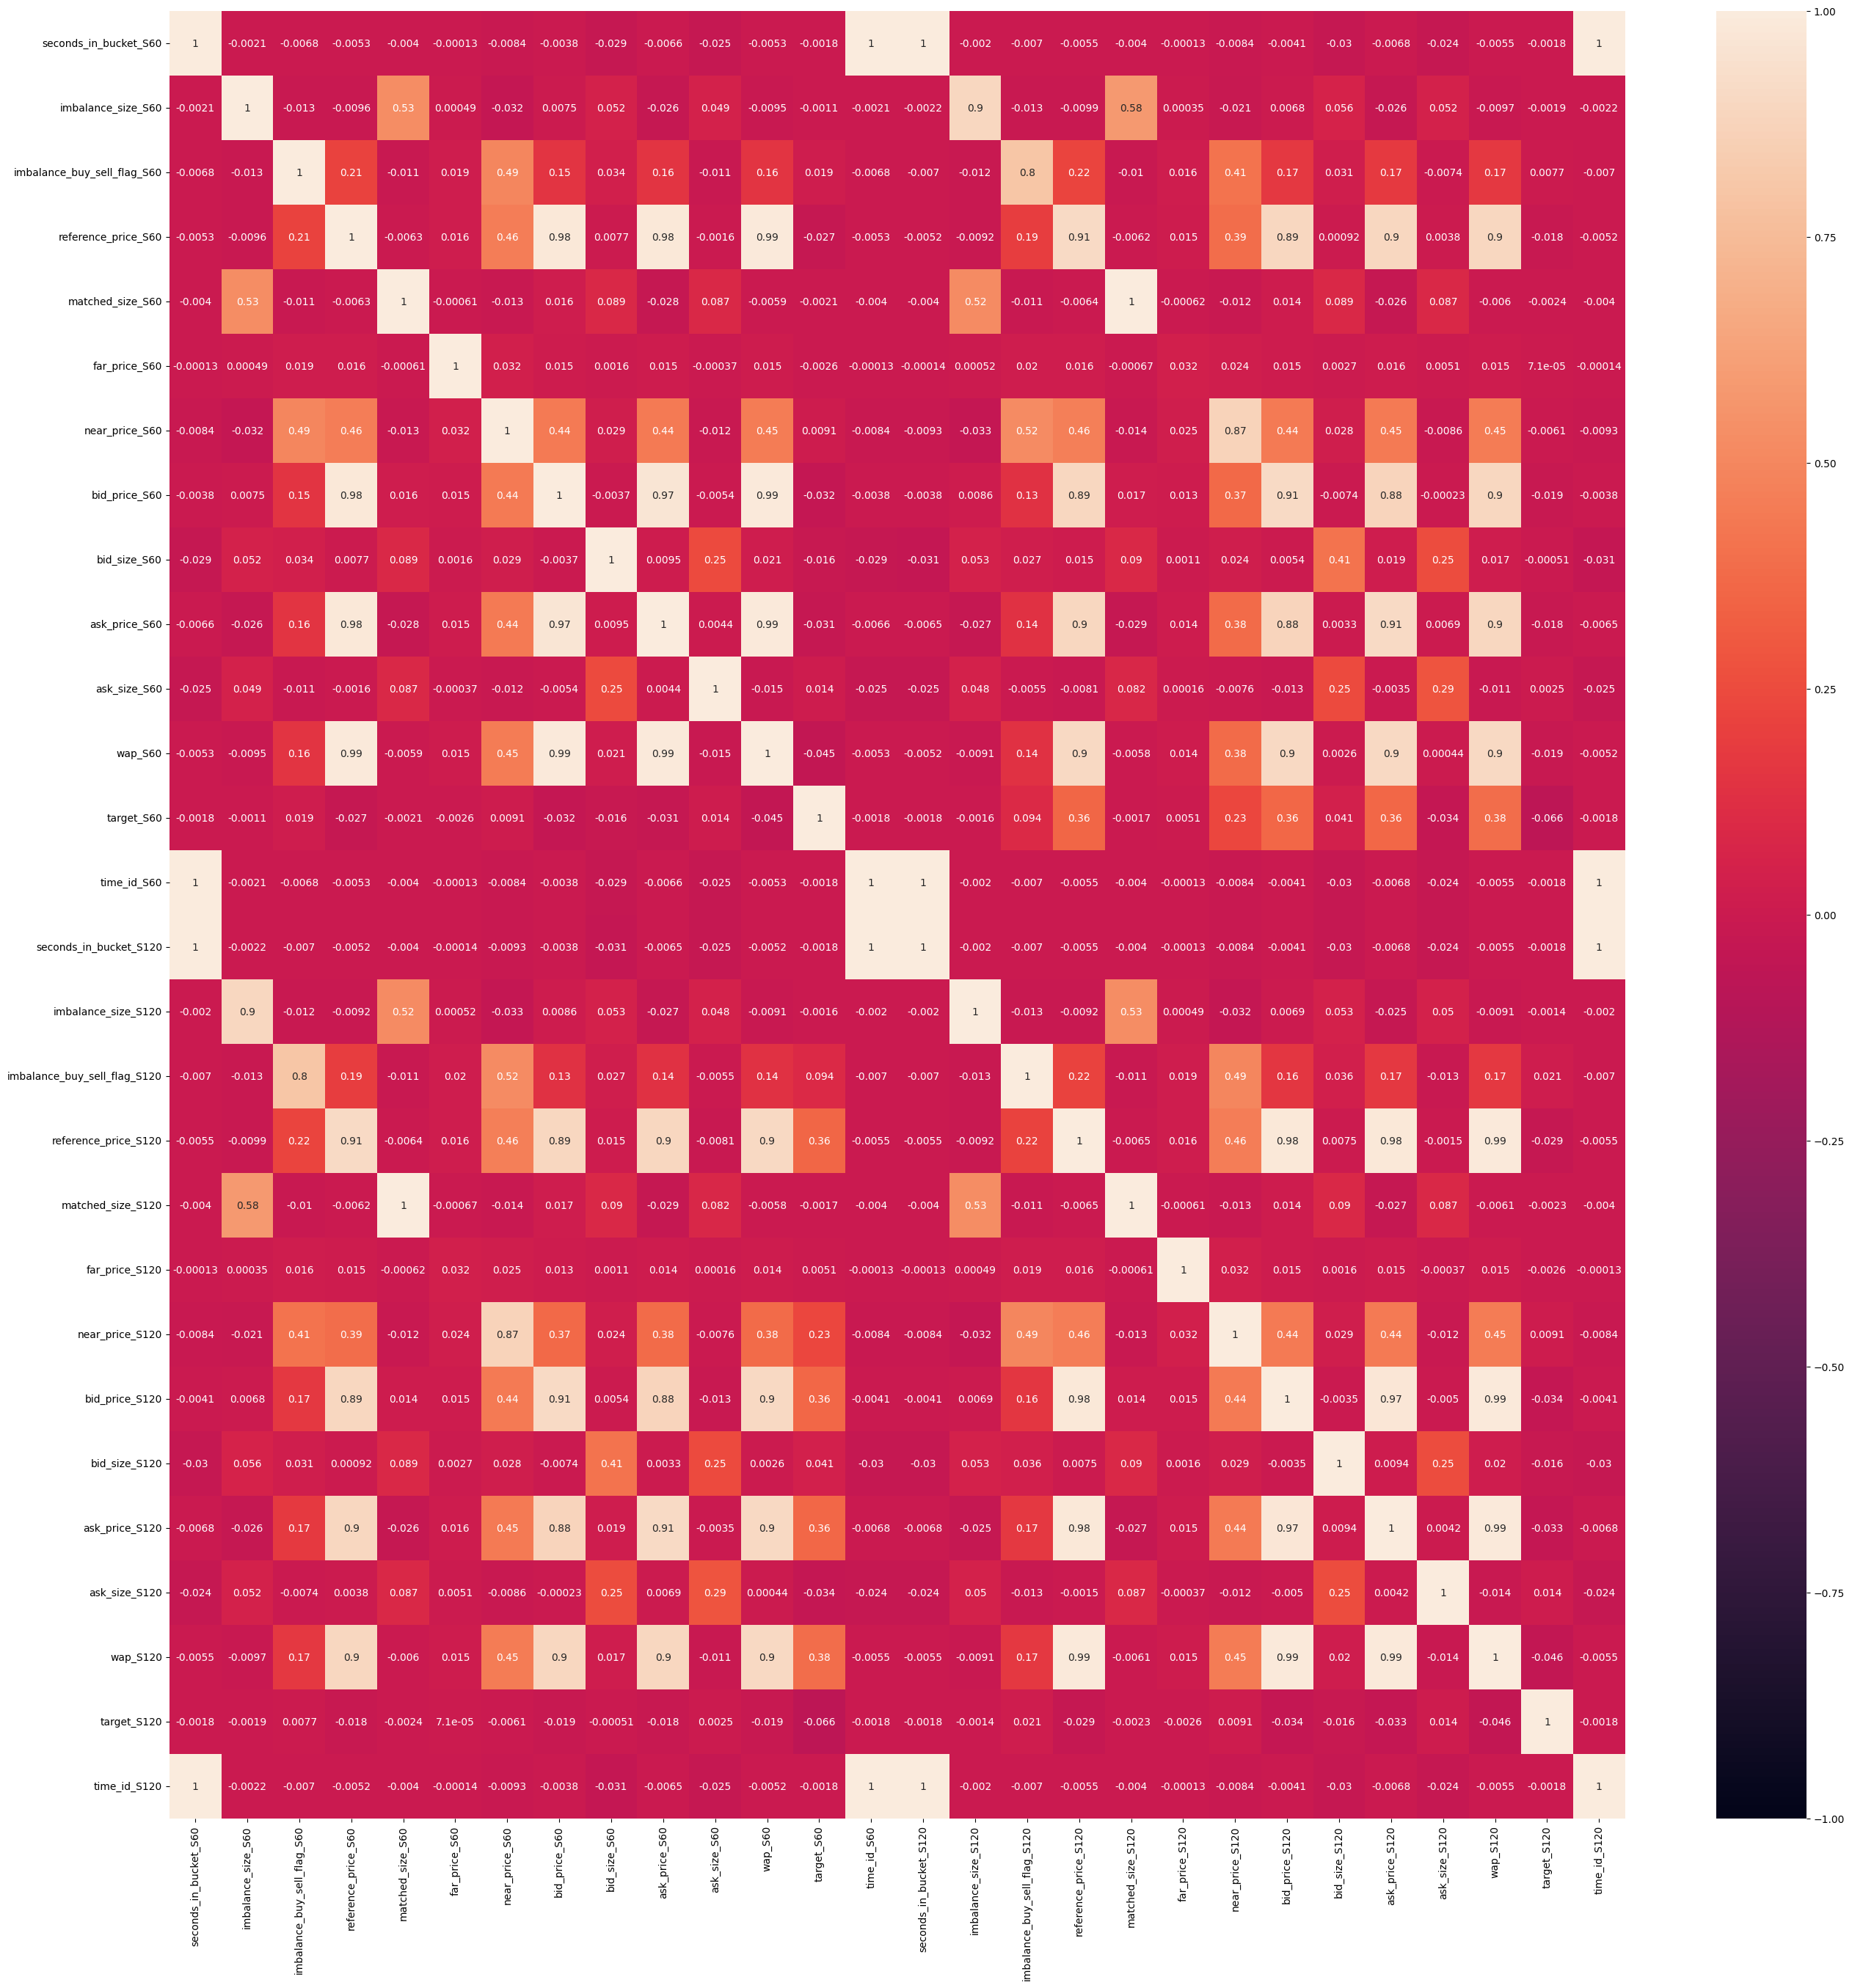

In [26]:
df_comp = df_shifted_dict[6].merge(df_shifted_dict[12], left_index = True, right_index = True)

plt.figure(figsize=(32,32))
cor = df_comp.corr(method='pearson')
sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
plt.show()

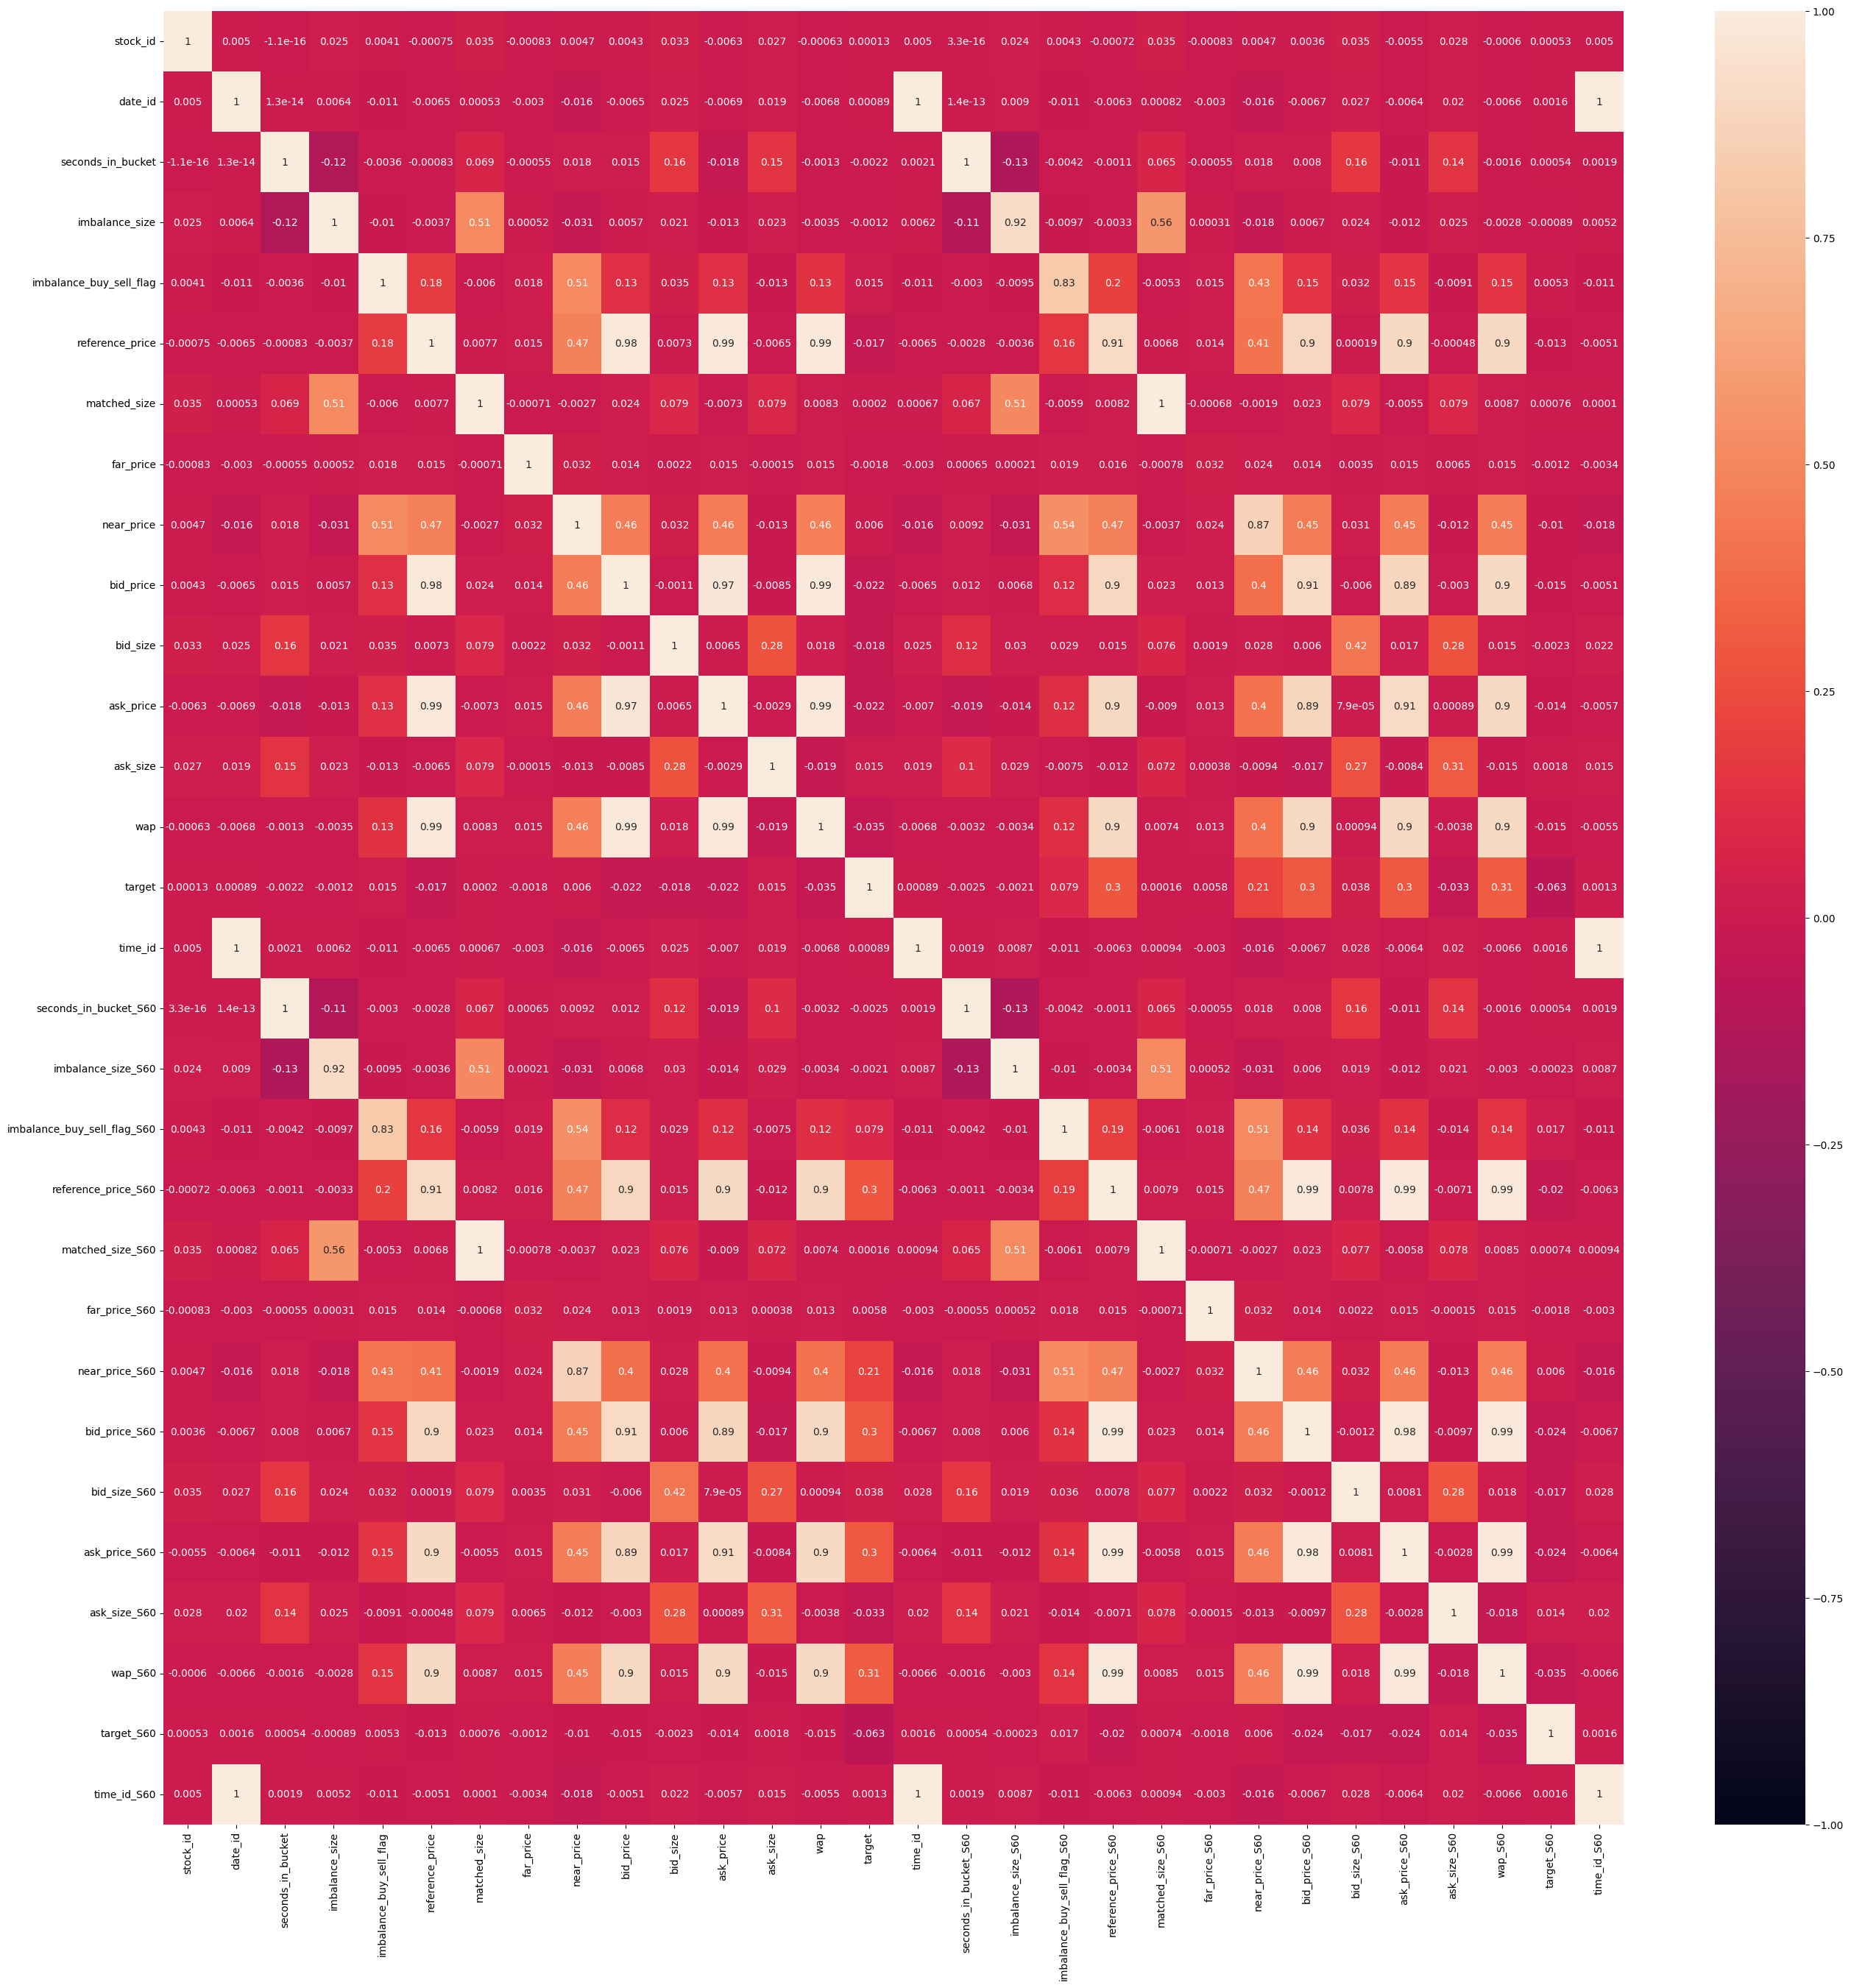

In [27]:
plt.figure(figsize=(32,32))
cor = df_comp_S60.corr(method='pearson')
sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
plt.show()

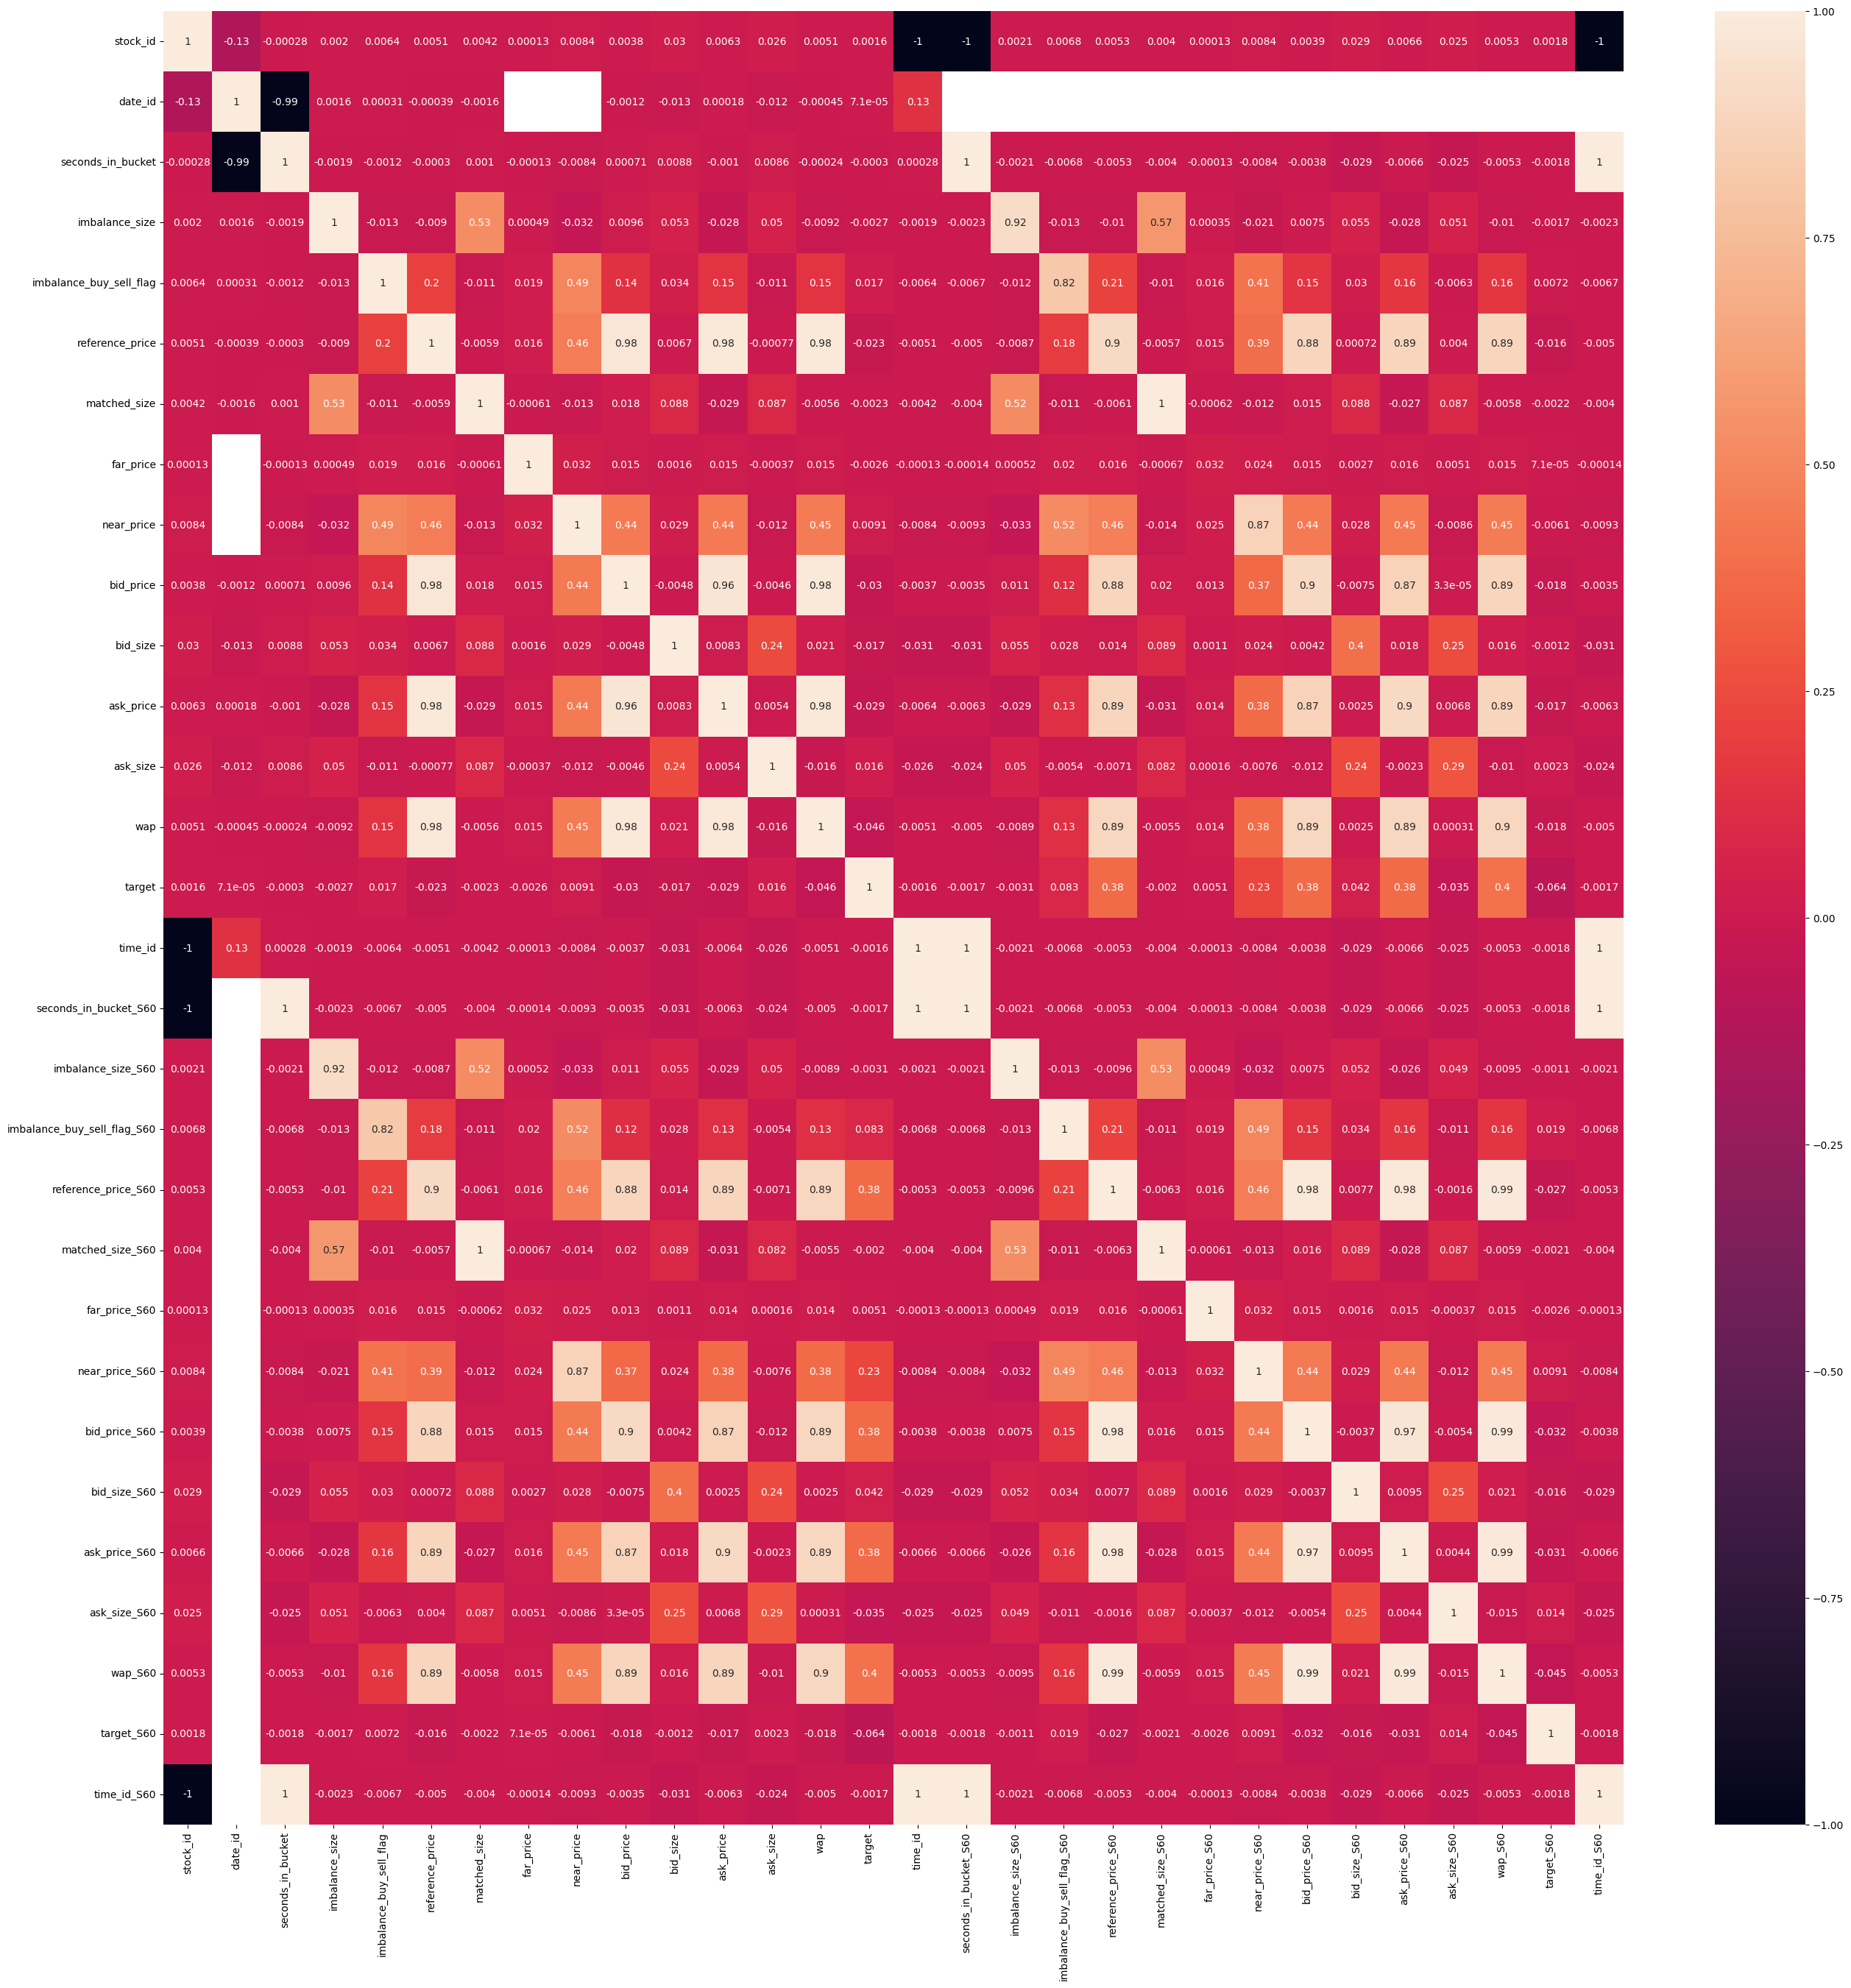

In [28]:
plt.figure(figsize=(32,32))
cor = df_diff1_comp_S60.corr(method='pearson')
sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
plt.show()

In [17]:
df_pivot_target = df.pivot(index=['stock_id','date_id'], columns='seconds_in_bucket', values='target')
df_pivot_target

seconds_in_bucket        0          10         20         30         40   \
stock_id date_id                                                           
0        0         -3.029704   0.389814   4.220009   5.450249   3.169775   
         1        -14.089942  -3.079772   2.540350   2.390146  -0.540018   
         2         -6.359816   1.159906   3.030300   5.730391   4.459619   
         3         -7.929802  -5.859733  -4.079938  -0.479817  -5.599856   
         4          5.919933  16.239882  14.679432  18.730164  13.209581   
...                      ...        ...        ...        ...        ...   
199      476        2.520084   5.489588   7.100105   6.270409  -0.600219   
         477       -7.029772  -5.570054  -9.459853 -11.810064  -4.090071   
         478      -11.900067  -8.890033  -9.059906  -6.849766  -3.679991   
         479        3.960133   3.269911   6.439686   6.200075   0.940561   
         480        9.479523   2.299547   1.850128   1.980066   4.969835   

seconds_in_bucket        50         60        70        80        90   ...  \
stock_id date_id                                                       ...   
0        0          0.599623  -0.200272  2.410412 -0.389814 -4.339814  ...   
         1          0.740290  -0.659823 -4.230142 -3.169775  1.469850  ...   
         2          4.949570   6.990433 -1.819730 -1.670122 -2.899766  ...   
         3          0.900030   1.499653  0.970364  0.220537  2.169609  ...   
         4         12.890101  14.159679  3.110170  3.010035  0.619888  ...   
...                      ...        ...       ...       ...       ...  ...   
199      476       -1.819730  -5.419850 -2.239943 -2.419949 -1.429915  ...   
         477       -4.630089  -3.740191 -6.229877 -2.110004  0.280142  ...   
         478        0.710487   4.019737  2.100468  4.479885  7.450581  ...   
         479        0.100136  -0.349879  3.429651  6.639957  9.859800  ...   
         480        4.869700   5.719662  4.409552  4.420280  3.880262  ...   

seconds_in_bucket       450       460       470       480       490       500  \
stock_id date_id                                                                
0        0         1.169443 -2.880096  0.129938 -1.320243  0.189543  0.979900   
         1         3.240108  3.180504  6.580353  2.900362  3.960133  4.630089   
         2         3.290176  2.679825  3.540516  0.040531  2.210140  3.410578   
         3         2.349615  5.060434  4.030466  7.859469  0.480413 -3.870130   
         4        -2.459884 -2.599955 -0.640154  2.919436 -5.490184 -4.889965   
...                     ...       ...       ...       ...       ...       ...   
199      476       0.809431 -0.709891 -0.060201 -1.360178 -4.420280 -9.120107   
         477      -2.089739  0.449419  3.709793  1.519918 -0.939965 -4.870296   
         478      -2.310276 -3.209710 -2.760291 -1.829863  1.809597  2.859831   
         479      -1.609922 -0.770092  1.529455  2.510548 -1.029968 -4.659891   
         480       9.020567  0.849962  0.760555  4.299879 -2.139807 -7.209778   

seconds_in_bucket        510       520        530        540  
stock_id date_id                                              
0        0          0.649691  6.779432   6.140471   9.759665  
         1          5.780458  6.799698   2.820492  -2.700090  
         2         -0.479817 -1.720190  -0.569820   2.019405  
         3         -5.180240 -7.230043  -7.870197  -8.149743  
         4         -4.959702 -5.750060  -6.920099 -12.429953  
...                      ...       ...        ...        ...  
199      476      -10.300279 -9.220242 -10.579824  -7.190108  
         477       -4.500151 -4.889965  -6.890297   1.239777  
         478        3.679991  6.020069  10.600090  11.420250  
         479       -4.739761 -5.440116  -8.689761  -7.609725  
         480       -9.750128  3.629923   4.760027  -6.530285  

[95236 rows x 55 columns]

In [5]:
df_0_0 = df_pivot_target.loc[199].loc[100]
df_0_0

seconds_in_bucket
0       0.089407
10      1.829863
20     -3.989935
30      1.740456
40      0.220537
50      0.339746
60      0.059605
70     -2.120137
80      3.290176
90     -1.320243
100    -2.539754
110    -0.370145
120    -1.609922
130     0.050068
140    -0.699758
150     0.419617
160     1.629591
170     0.849962
180     2.219677
190     1.319647
200     2.059937
210     1.250505
220    -7.820129
230    -5.869865
240    -3.399849
250    -0.799894
260     0.790358
270     5.309582
280    13.509989
290    10.169745
300     8.380413
310     5.220175
320     4.069805
330    -0.839829
340    -0.470281
350     0.300407
360    -0.540018
370     4.060268
380     4.090071
390     5.660057
400     9.319782
410    10.490417
420    11.670589
430     2.239943
440     1.989603
450     1.909733
460    -1.059771
470    -1.879930
480    -2.800226
490     3.039837
500     4.600287
510     3.410578
520     1.490116
530     5.120039
540    -0.990033
Name: 100, dtype: float64

In [174]:
#pacf(df_0_0.diff(6).iloc[6:], method = 'ols')

In [204]:
df_0_0_d1 = df_0_0.diff(1).dropna().to_frame(name = 'target_diff_1')
'''
calcoliamo la varianza e la media al minuto per poi dividere i valori target per la varianza del minuto corrispondente
per poi sottrarre il valore della media
'''
#(stiamo assumento una seasonality di 60 secondi, come suggerito dal PACF e dal calcolo dei dati di input)
df_0_0_d1['minuto'] = ((df_0_0_d1.index - 0.01) / 60).astype(int)
df_0_0_d1 = df_0_0_d1.merge(df_0_0_d1.groupby('minuto').agg(['std', 'mean'])['target_diff_1'].rename(columns = {'std':'std_1','mean':'mean_1'}),\
                left_on = 'minuto',\
                right_index = True)
df_0_0_d1['target_inverse_Z_norm'] = (df_0_0_d1['target_diff_1'] / df_0_0_d1['std_1']) - df_0_0_d1['mean_1']
df_0_0_d1['target_mean_diff'] = df_0_0_d1['target_diff_1'] - df_0_0_d1['mean_1']

df_0_0_d1['true_norm_1_minute'] = (df_0_0_d1['target_diff_1'] - df_0_0_d1['mean_1'])/ df_0_0_d1['std_1']


df_0_0_d1

,target_diff_1,minuto,std_1,mean_1,target_inverse_Z_norm,target_mean_diff,true_norm_1_minute
seconds_in_bucket,,,,,,,
10,1.740456,0,3.798402,-0.004967,0.463174,1.745423,0.459515
20,-5.819798,0,3.798402,-0.004967,-1.527203,-5.814831,-1.530862
30,5.730391,0,3.798402,-0.004967,1.513599,5.735358,1.509939
40,-1.519918,0,3.798402,-0.004967,-0.395180,-1.514951,-0.398839
50,0.119209,0,3.798402,-0.004967,0.036351,0.124176,0.032692
60,-0.280142,0,3.798402,-0.004967,-0.068785,-0.275175,-0.072445
70,-2.179742,1,3.536825,-0.278254,-0.338045,-1.901487,-0.537626
80,5.410314,1,3.536825,-0.278254,1.807964,5.688568,1.608383
90,-4.610419,1,3.536825,-0.278254,-1.025293,-4.332165,-1.224874


In [191]:
adfuller(df_0_0)

(-1.7310769922969318,
 0.4151759670792504,
 6,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 216.15855632677238)

In [170]:
adfuller(df_0_0_d1['target_diff_1'])

(-6.680743285270203,
 4.348723907680264e-09,
 5,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 213.80546524802435)

In [202]:
adfuller(df_0_0_d1['true_norm_1_minute'])

(-4.251041539991932,
 0.0005393966468877347,
 11,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 99.4097171766376)

In [205]:
adfuller(df_0_0_d1['target_mean_diff'])

(-5.455857063449161,
 2.5827450512394036e-06,
 6,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 205.83600744636976)

In [194]:
adfuller(df_0_0_d1['target_inverse_Z_norm'])

(-6.422670544282022,
 1.7756105407413885e-08,
 5,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 122.36144102574193)

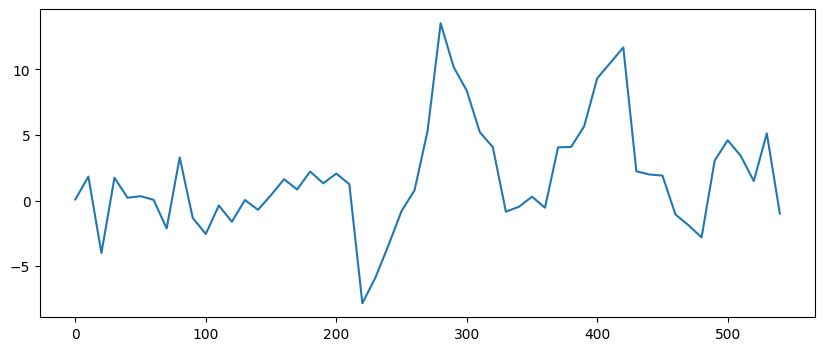

In [195]:
plt.figure(figsize=(10,4))
plt.plot(df_0_0)
#plt.ylim(-11, 11)
plt.show()

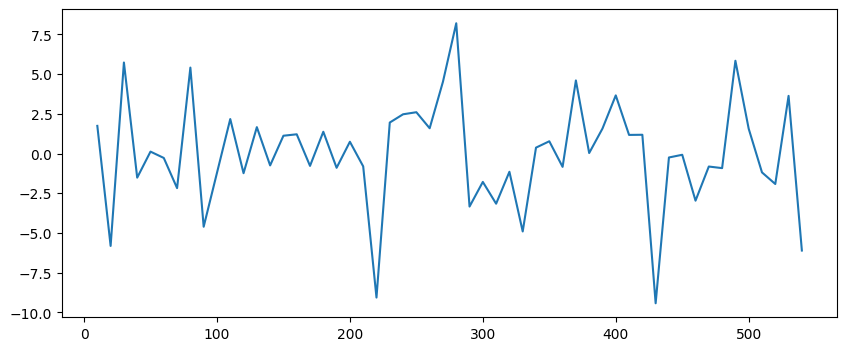

In [196]:
plt.figure(figsize=(10,4))
plt.plot(df_0_0_d1['target_diff_1'])
#plt.ylim(-11, 11)
plt.show()

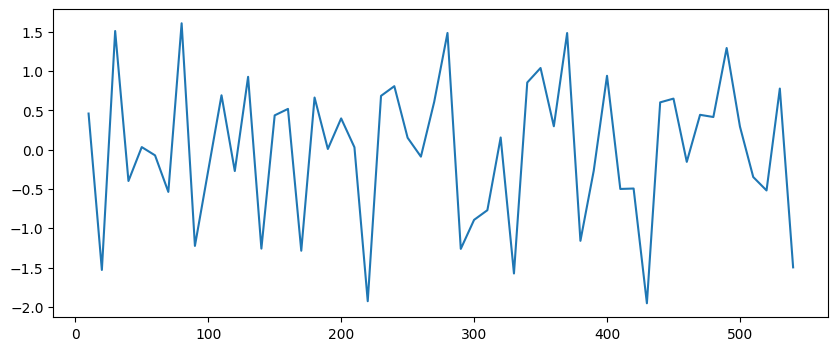

In [203]:
plt.figure(figsize=(10,4))
plt.plot(df_0_0_d1['true_norm_1_minute'])
#plt.ylim(-11, 11)
plt.show()

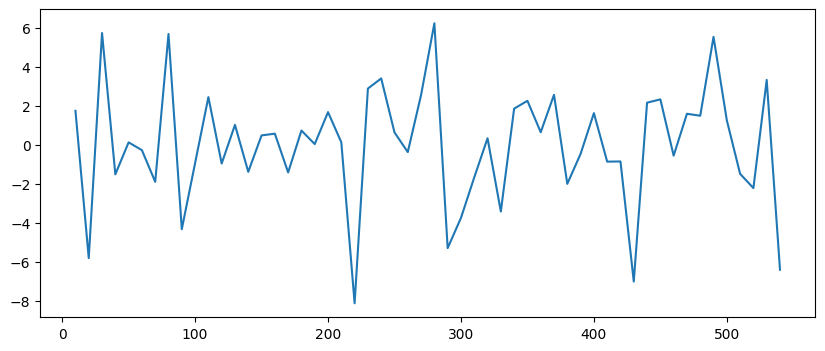

In [206]:
plt.figure(figsize=(10,4))
plt.plot(df_0_0_d1['target_mean_diff'])
#plt.ylim(-11, 11)
plt.show()

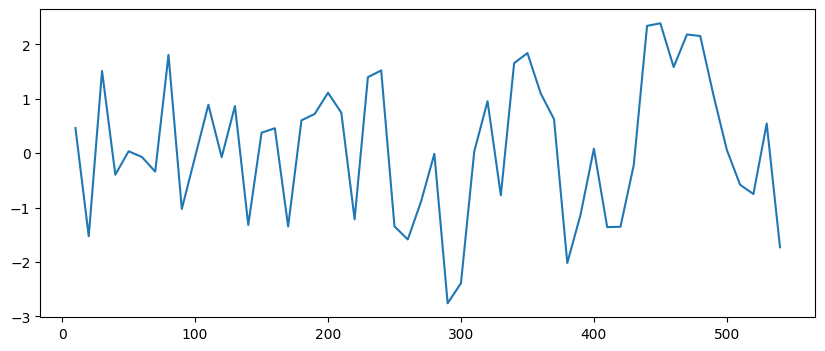

In [198]:
plt.figure(figsize=(10,4))
plt.plot(df_0_0_d1['target_inverse_Z_norm'])
#plt.ylim(-11, 11)
plt.show()

In [6]:
[0,1,2,1,5,6,1]
[1,1,-1,4,1,-5]
df_0_0

seconds_in_bucket
0       0.089407
10      1.829863
20     -3.989935
30      1.740456
40      0.220537
50      0.339746
60      0.059605
70     -2.120137
80      3.290176
90     -1.320243
100    -2.539754
110    -0.370145
120    -1.609922
130     0.050068
140    -0.699758
150     0.419617
160     1.629591
170     0.849962
180     2.219677
190     1.319647
200     2.059937
210     1.250505
220    -7.820129
230    -5.869865
240    -3.399849
250    -0.799894
260     0.790358
270     5.309582
280    13.509989
290    10.169745
300     8.380413
310     5.220175
320     4.069805
330    -0.839829
340    -0.470281
350     0.300407
360    -0.540018
370     4.060268
380     4.090071
390     5.660057
400     9.319782
410    10.490417
420    11.670589
430     2.239943
440     1.989603
450     1.909733
460    -1.059771
470    -1.879930
480    -2.800226
490     3.039837
500     4.600287
510     3.410578
520     1.490116
530     5.120039
540    -0.990033
Name: 100, dtype: float64

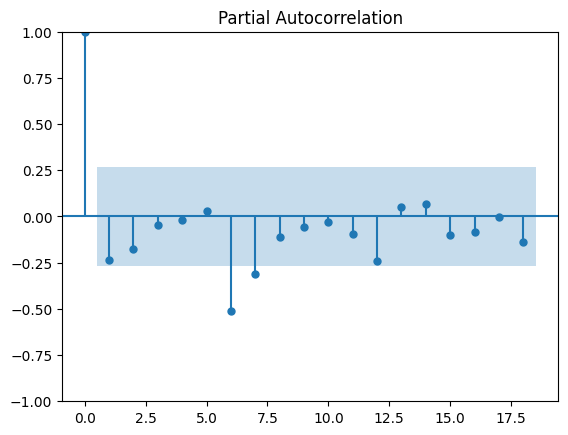

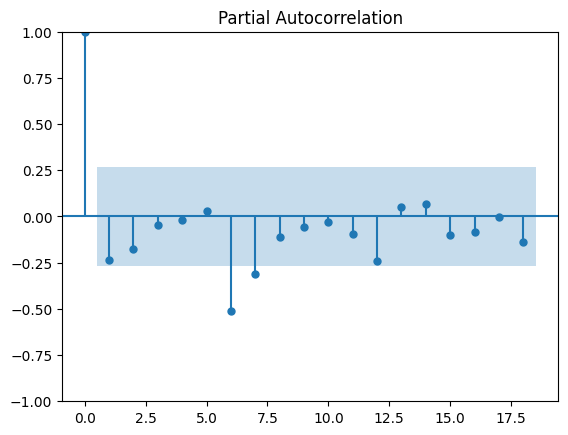

In [207]:
plot_pacf(df_0_0_d1['target_mean_diff'])

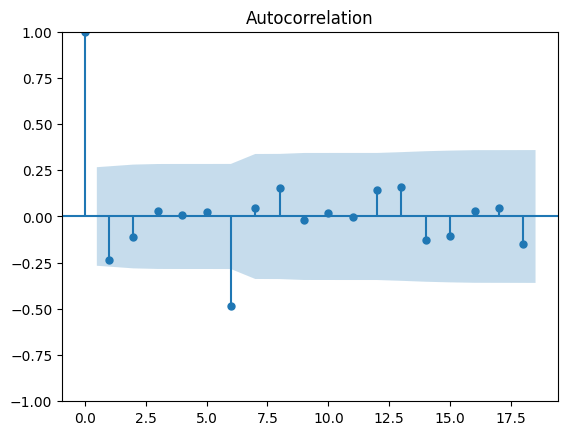

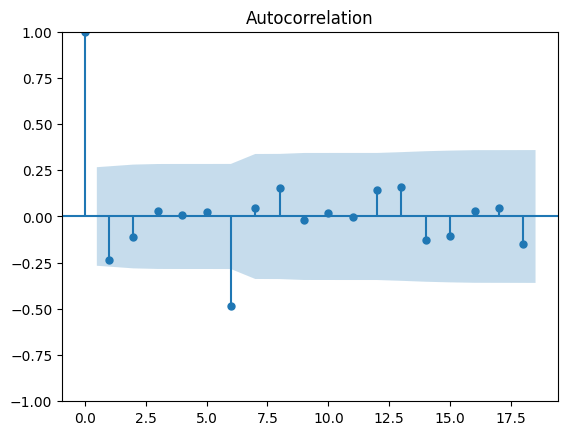

In [208]:
plot_acf(df_0_0_d1['target_mean_diff'])

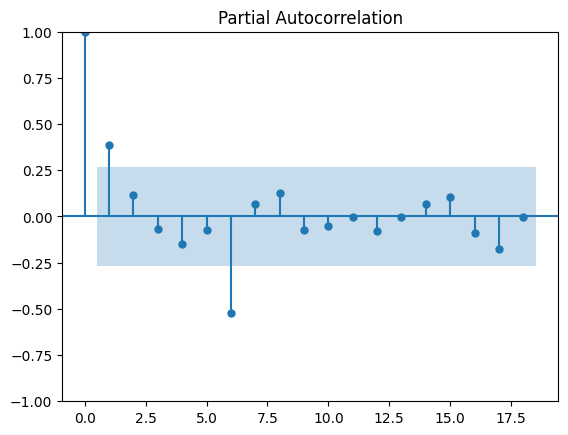

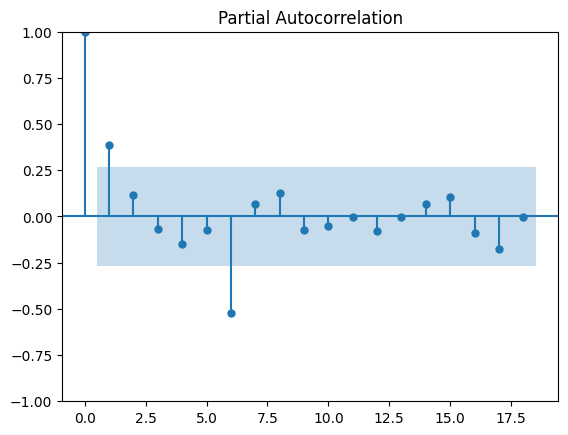

In [185]:
plot_pacf(df_0_0_d1['target_inverse_Z_norm'])

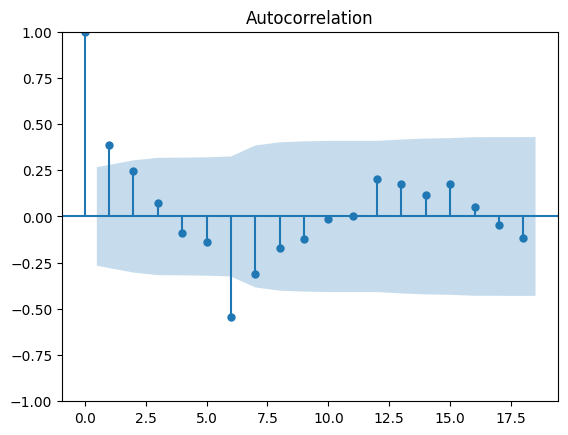

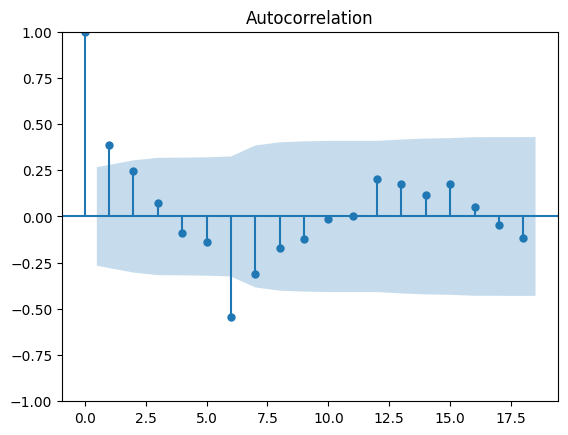

In [186]:
plot_acf(df_0_0_d1['target_inverse_Z_norm'])

## Features Correlation

Let's dive more into the correlation among these features, using the Pearson correlation:

In [ ]:
1
2
3
4
5
6
7
8
-- --

C:\Users\loren\AppData\Local\Temp\ipykernel_6808\3279455266.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr(method='pearson')


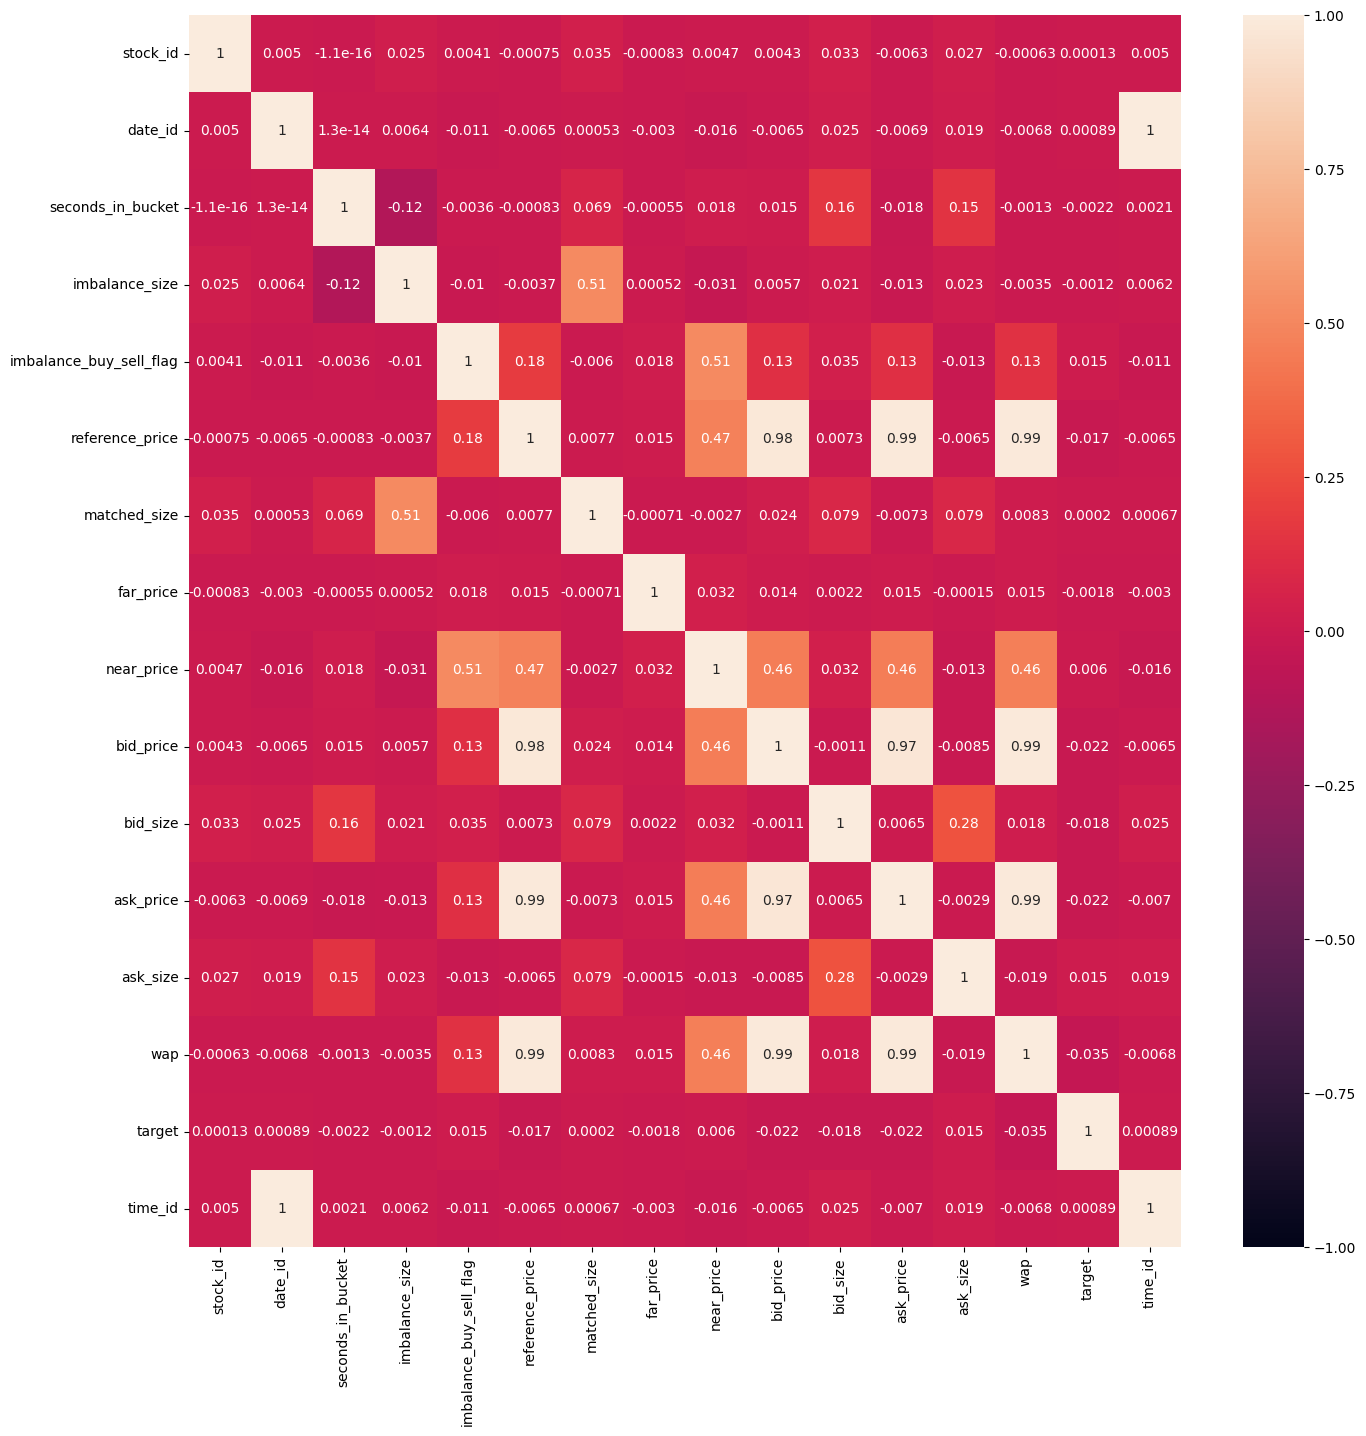

In [6]:
plt.figure(figsize=(16,16))
cor = df.corr(method='pearson')
sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
plt.show()

Interesting facts can be drawn from this correlation grid:
- **reference_price**, **ask_price**, **bid_price**, **wap** are all highly interrelated among each other (0.98-0.99): this is something we expect, as long as *"reference_price"* is the final price, and it's always included between the *"ask_price"* (selling - lowest higher one) and the *"bid_price"* (buying - highest lower one). On the other hand, *"wap"* is a calculated field, directly derived from *"bid_price"* and *"ask_price"*.
- **near_price** has a positive correlation of 0.46 with **ask/bid/reference_price**, **imbalance_buy_sell_flag** has a positive correlation of 0.51 with **near_price**, but correlation between **imbalance_buy_sell_flag** and **ask/bid/reference_price** is only 0.13.
- **imbalance_size** has a positive correlation of 0.51 with **matched_size**: this is due to the fact that the imbalance is derived directly from the matched_size, positively or negatively according to the position of imbalance (towards selling or buying part).
- **bid_size** has a positive correlation of 0.28 with **ask_size**.


In [7]:
near       ask             imbalance  
1           1                1
2           2                3 
3           4                3

SyntaxError: invalid syntax (229419414.py, line 1)

Since *"far_price"* and *"near_price"* are always null in the first five minutes, let's check correlations in the timeframe 5-9 minutes.

In [24]:
df_5_9_min = df.loc[df['seconds_in_bucket'] >= 300]
df_5_9_min

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30,0_300_0
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,30,0_300_1
5732,2,0,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,30,0_300_2
5733,3,0,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,30,0_300_3
5734,4,0,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,30,0_300_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


C:\Users\loren\AppData\Local\Temp\ipykernel_6808\1499292306.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_5_9_min.corr(method='pearson')


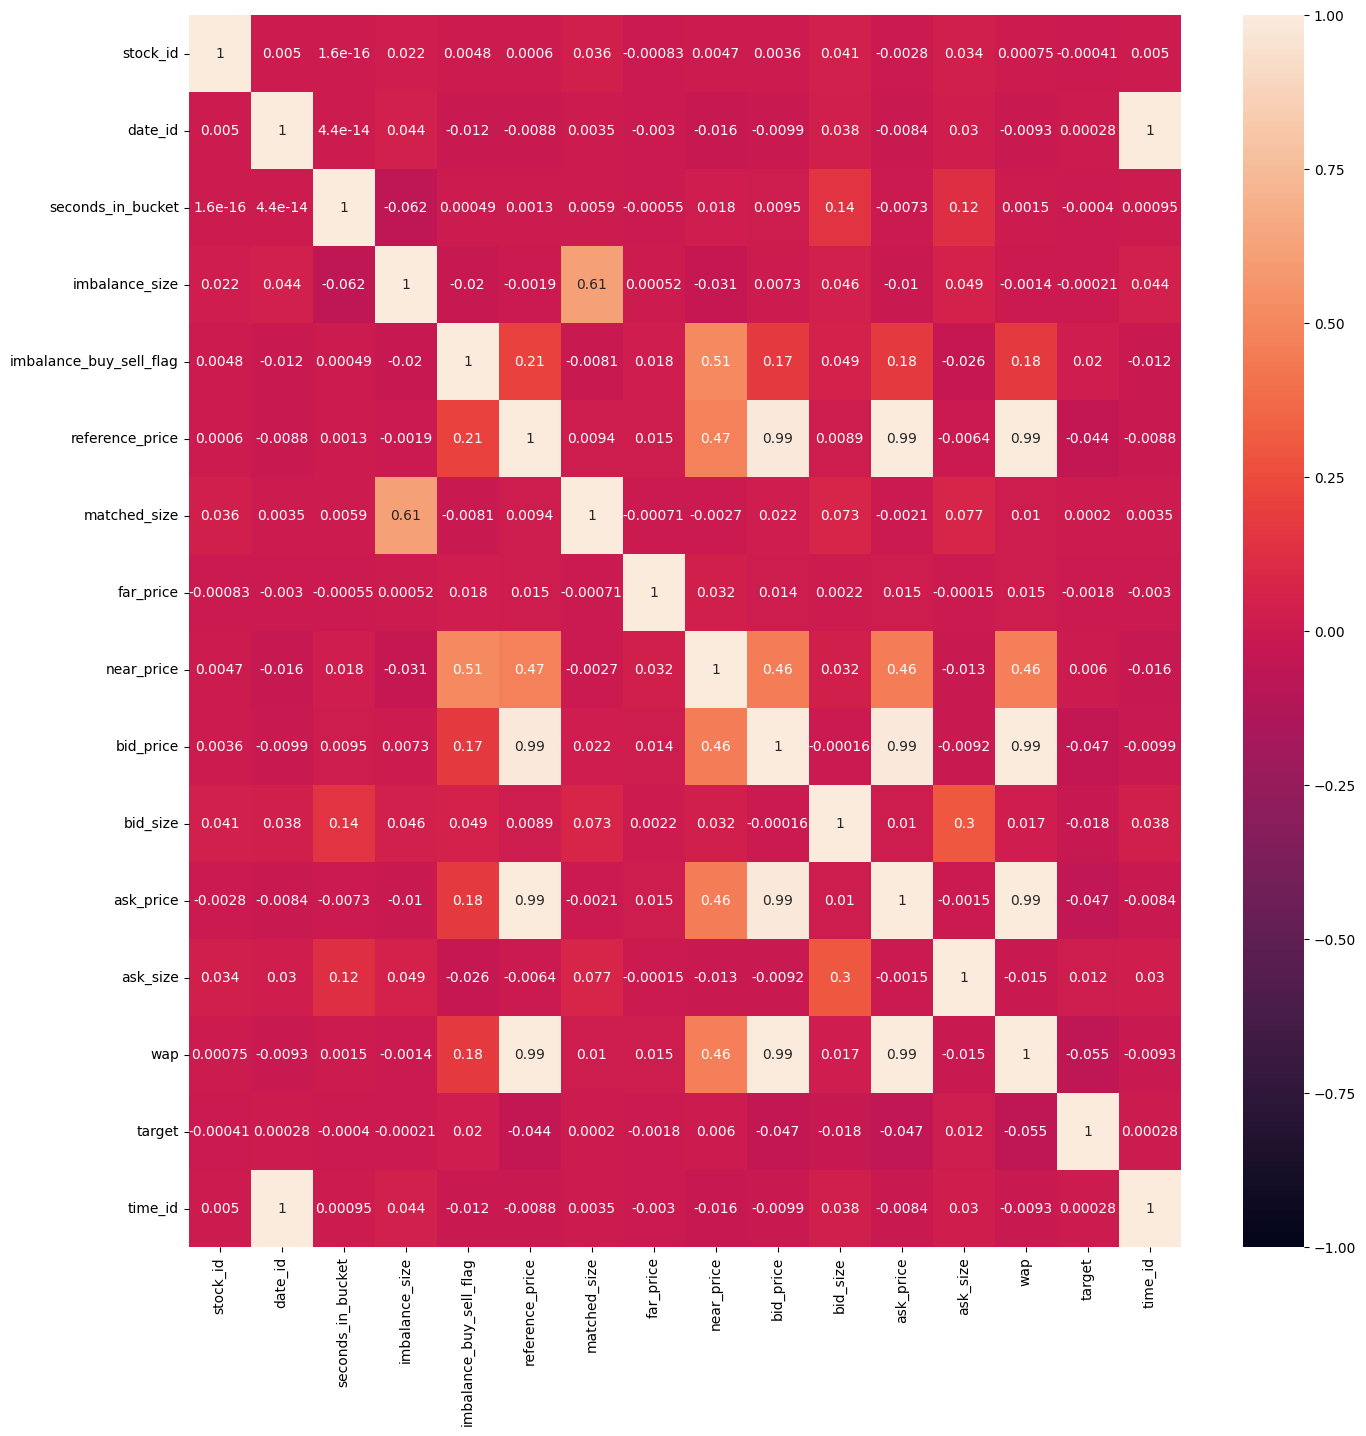

In [9]:
plt.figure(figsize=(16,16))
cor = df_5_9_min.corr(method='pearson')
sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
plt.show()

In [28]:
df_5_9_min[['stock_id','date_id', 'target']].groupby(['stock_id','date_id'], group_keys=True).apply(lambda x: x.diff(1))

stock_id  date_id  seconds_in_bucket  \
stock_id date_id                                                 
0        0       5730            0        0                300   
                 5921            0        0                310   
                 6112            0        0                320   
                 6303            0        0                330   
                 6494            0        0                340   
...                            ...      ...                ...   
199      480     5237179       199      480                500   
                 5237379       199      480                510   
                 5237579       199      480                520   
                 5237779       199      480                530   
                 5237979       199      480                540   

                          imbalance_size  imbalance_buy_sell_flag  \
stock_id date_id                                                    
0        0       5730               0.00                        0   
                 5921               0.00                        0   
                 6112               0.00                        0   
                 6303               0.00                        0   
                 6494               0.00                        0   
...                                  ...                      ...   
199      480     5237179      2661783.46                       -1   
                 5237379      2658917.61                       -1   
                 5237579      1352558.88                       -1   
                 5237779      1352558.88                       -1   
                 5237979      1884285.71                       -1   

                          reference_price  matched_size  far_price  \
stock_id date_id                                                     
0        0       5730            1.000241   26670118.88   1.000241   
                 5921            0.999919   26670118.88   0.999919   
                 6112            0.999919   26670118.88   0.999919   
                 6303            0.999812   26670118.88   0.999812   
                 6494            0.999491   26670118.88   0.999491   
...                                   ...           ...        ...   
199      480     5237179         1.002764   23969215.23   1.000859   
                 5237379         1.002764   23972081.09   1.000859   
                 5237579         1.001812   23978379.68   1.000859   
                 5237779         1.001812   23978379.68   1.000859   
                 5237979         1.002129   24073677.32   1.000859   

                          near_price  bid_price   bid_size  ask_price  \
stock_id date_id                                                        
0        0       5730       1.000241   1.000026   19319.31   1.000241   
                 5921       0.999919   0.999812   22767.64   0.999919   
                 6112       0.999919   0.999705   49262.40   0.999919   
                 6303       0.999812   0.999705   27990.00   0.999812   
                 6494       0.999491   0.999169   18743.25   0.999383   
...                              ...        ...        ...        ...   
199      480     5237179    1.001494   1.002764  122246.18   1.003082   
                 5237379    1.001494   1.002764  677012.04   1.003082   
                 5237579    1.001494   1.001812  225361.65   1.002129   
                 5237779    1.001494   1.001812  285559.05   1.002129   
                 5237979    1.001494   1.002129  250081.44   1.002447   

                           ask_size       wap     target  time_id       row_id  
stock_id date_id                                                                
0        0       5730      16149.55  1.000143 -10.039806       30      0_300_0  
                 5921      18664.00  0.999871  -6.039739       31      0_310_0  
                 6112      37607.96  0.999826  -5.440116       32      0_320_0  
   

In [10]:
df_shifted_target_1min = df_5_9_min.copy(deep = True)
df_shifted_target_1min = df_shifted_target_1min.sort_values(['stock_id', 'date_id'])
df_shifted_target_1min['target'] = df_shifted_target_1min['target'].shift(+6)
df_shifted_target_1min = df_shifted_target_1min.loc[df_shifted_target_1min['seconds_in_bucket'] > 350]

C:\Users\loren\AppData\Local\Temp\ipykernel_6808\3529146112.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_shifted_target_1min.corr(method='pearson')


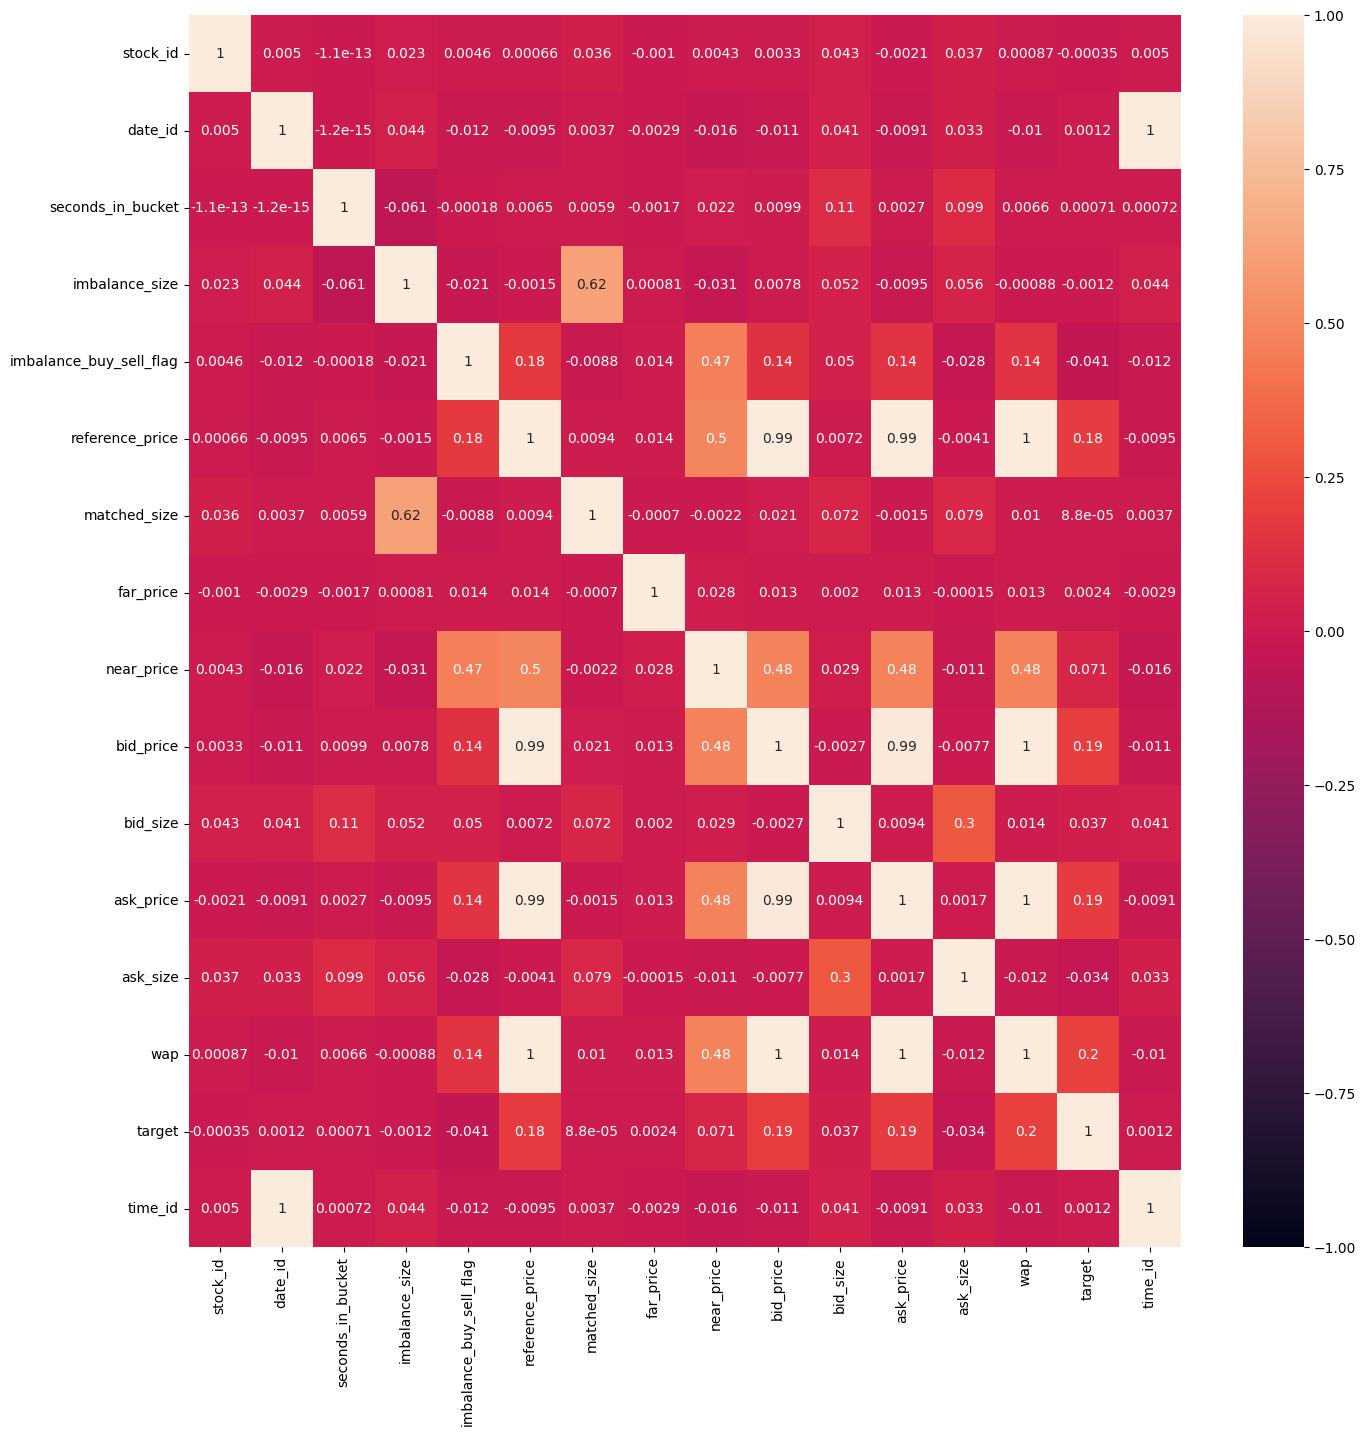

In [11]:
plt.figure(figsize=(16,16))
cor = df_shifted_target_1min.corr(method='pearson')
sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
plt.show()

Variations in numbers are negligible.

In [12]:
#acf/pacf

In [13]:
1 nan ---
2 1
3 2
4 3
5 4
6 5

1 6 ---
2 1
3 2

SyntaxError: invalid syntax (1663816907.py, line 1)

# 2. Data Preprocessing

In [7]:
filtered_df = df.copy(deep=True)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [8]:
filtered_df['stock_id'].value_counts().value_counts()

26455    189
26400      2
24420      2
26235      1
23210      1
22605      1
21615      1
16500      1
15950      1
10230      1
Name: stock_id, dtype: int64

The distribution of records for each stock is not equal. Most stocks (189) have 26k records, 11 have between 26400 and 10230 records (even much less). 

Let's slice out stocks that have a partial amount of records. 

In [9]:
'''vc = filtered_df['stock_id'].value_counts()
filtered_df = filtered_df[filtered_df['stock_id'].isin(vc[vc == 26455].index)]
filtered_df'''
#ricordiamoci di eliminare i nan in maniera specifica e non derivata da altre variabili

"vc = filtered_df['stock_id'].value_counts()\nfiltered_df = filtered_df[filtered_df['stock_id'].isin(vc[vc == 26455].index)]\nfiltered_df"

In [10]:
filtered_df['date_id'].value_counts().value_counts()

11000    185
10945    105
10835     92
10560     33
10670     22
10780     19
10725     11
10890     10
10505      4
Name: date_id, dtype: int64

Every stock in this slice has the same amount of dates.

In [11]:
filtered_df.groupby('stock_id')['seconds_in_bucket'].nunique().value_counts()

55    200
Name: seconds_in_bucket, dtype: int64

Every stock in this slice has the same amount of minute values per day (from 0 to 540 at a step of 10).

## Null Values Wrangling

In [12]:
print(len(filtered_df))
filtered_df.isnull().sum(axis=0)

5237980


stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

By limiting the time series to the minutes between 5 and 9, we should remove most of the null values, due to the missing *"far_price"* and *"near_price"*.

In [13]:
filtered_df_59 = filtered_df[filtered_df['seconds_in_bucket'] >= 300]
filtered_df_59

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30,0_300_0
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,30,0_300_1
5732,2,0,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,30,0_300_2
5733,3,0,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,30,0_300_3
5734,4,0,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,30,0_300_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


eliminiamo le variabili poco significative o quelle altamente correlate ad altre (per esempio il wap spiega meglio l'anadamento del target 
--> eliminiamo reference, bid e ask prices)

In [14]:
filtered_df_59.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [15]:
filtered_df_59.drop(columns = ['reference_price','bid_price','ask_price','time_id', 'row_id'], inplace = True)

C:\Users\loren\AppData\Local\Temp\ipykernel_19552\2636235041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_59.drop(columns = ['reference_price','bid_price','ask_price','time_id', 'row_id'], inplace = True)


In [16]:
#eliminino tutte le righe con almeno un valore nullo
for column in filtered_df_59.columns:
    filtered_df_59 = filtered_df_59.loc[pd.notna(filtered_df_59[column])]

In [17]:
print(len(filtered_df_59))
filtered_df_59.isnull().sum(axis=0)

2343638


stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
matched_size               0
far_price                  0
near_price                 0
bid_size                   0
ask_size                   0
wap                        0
target                     0
dtype: int64

In [18]:
shifter = 6
target = filtered_df_59[['stock_id','date_id','seconds_in_bucket','target']]
target = target.sort_values(['stock_id', 'date_id'])
target['target_lag_6'] = target['target'].shift(+shifter)
target = target.loc[target['seconds_in_bucket'] >= 300 + shifter * 10]
target['difference'] = target['target'] - target['target_lag_6']
target

,stock_id,date_id,seconds_in_bucket,target,target_lag_6,difference
6876,0,0,360,-2.729893,-10.039806,7.309913
7067,0,0,370,-4.240274,-6.039739,1.799464
7258,0,0,380,-4.259944,-5.440116,1.180172
7449,0,0,390,-2.009869,-7.439852,5.429983
7640,0,0,400,0.519752,-2.700090,3.219843
...,...,...,...,...,...,...
5237179,199,480,500,-7.209778,8.859634,-16.069412
5237379,199,480,510,-9.750128,9.020567,-18.770695
5237579,199,480,520,3.629923,0.849962,2.779961
5237779,199,480,530,4.760027,0.760555,3.999472


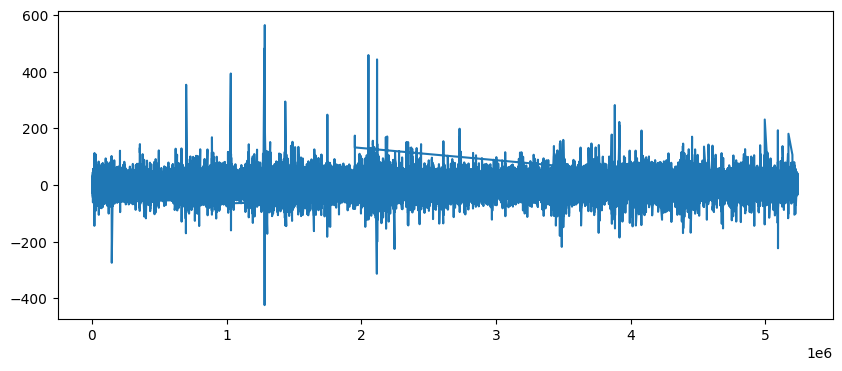

In [19]:
plt.figure(figsize=(10,4))
plt.plot(target.difference)


## 3. Feature Selection

In [20]:
df_features_selected = df[['stock_id', 'date_id','seconds_in_bucket','near_price','wap','target']]
df_features_selected = df_features_selected.loc[df_features_selected.notna().all(axis=1)]

In [21]:
df_D1_S6 = df_features_selected.groupby(['stock_id', 'date_id'], group_keys=True)['near_price','wap','target']\
                           .apply(lambda x: x.diff(1).shift(6))\
                           .reset_index()\
                           .set_index('level_2')
df_D1_S6.rename(columns = dict(zip(df_D1_S6.columns, ['f_' + col for col in df_D1_S6.columns])), inplace=True)

C:\Users\loren\AppData\Local\Temp\ipykernel_19552\2483329856.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_D1_S6 = df_features_selected.groupby(['stock_id', 'date_id'], group_keys=True)['near_price','wap','target']\


In [22]:
df_t_D1_S0 = df_features_selected.groupby(['stock_id', 'date_id'], group_keys=True)['target']\
                           .apply(lambda x: x.diff(1))\
                           .reset_index()\
                           .set_index('level_2')

In [23]:
df_D1_S6['f_seconds_in_bucket'] = df_features_selected['seconds_in_bucket']

In [24]:
df_D1_S6['target'] = df_t_D1_S0['target']

In [25]:
df_D1_S6 = df_D1_S6.loc[df_D1_S6.notna().all(axis=1)]

## 4. Feature Engineering

In [26]:
df_engineered = pd.DataFrame(index = df_D1_S6.index)

In [27]:
df_dummies_stocks = pd.get_dummies(df_D1_S6['f_stock_id'])
df_dummies_stocks.columns = ['f_s_' + str(stock_id) for stock_id in df_dummies_stocks.columns]
df_dummies_stocks

,f_s_0,f_s_1,f_s_2,f_s_3,f_s_4,f_s_5,f_s_6,f_s_7,f_s_8,f_s_9,...,f_s_190,f_s_191,f_s_192,f_s_193,f_s_194,f_s_195,f_s_196,f_s_197,f_s_198,f_s_199
level_2,,,,,,,,,,,,,,,,,,,,,
7067,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7258,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7449,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7640,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7831,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5237379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5237579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
df_engineered = pd.concat([df_D1_S6.drop(columns = ['f_stock_id']), df_dummies_stocks], axis = 1)

In [29]:
df_engineered

,f_date_id,f_near_price,f_wap,f_target,f_seconds_in_bucket,target,f_s_0,f_s_1,f_s_2,f_s_3,...,f_s_190,f_s_191,f_s_192,f_s_193,f_s_194,f_s_195,f_s_196,f_s_197,f_s_198,f_s_199
level_2,,,,,,,,,,,,,,,,,,,,,
7067,0,-0.000322,-0.000272,4.000067,370,-1.510382,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7258,0,0.000000,-0.000045,0.599623,380,-0.019670,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7449,0,-0.000107,-0.000050,-1.999736,390,2.250075,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7640,0,-0.000321,-0.000539,4.739761,400,2.529621,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7831,0,-0.000322,-0.000135,-1.769662,410,0.730753,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237179,480,0.000000,0.000006,7.429123,500,-5.069971,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5237379,480,0.000000,-0.000025,0.160933,510,-2.540350,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5237579,480,0.000000,-0.000007,-8.170605,520,13.380051,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
for col in ['f_date_id', 'f_near_price', 'f_wap', 'f_target', 'f_seconds_in_bucket']:
    df_engineered[col] = StandardScaler().fit_transform(df_engineered[col].to_frame())

In [31]:
df_engineered

,f_date_id,f_near_price,f_wap,f_target,f_seconds_in_bucket,target,f_s_0,f_s_1,f_s_2,f_s_3,...,f_s_190,f_s_191,f_s_192,f_s_193,f_s_194,f_s_195,f_s_196,f_s_197,f_s_198,f_s_199
level_2,,,,,,,,,,,,,,,,,,,,,
7067,-1.743352,-0.132208,-0.566693,0.692395,-1.638356,-1.510382,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7258,-1.743352,-0.012844,-0.090163,0.101649,-1.445608,-0.019670,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7449,-1.743352,-0.052508,-0.100660,-0.349928,-1.252861,2.250075,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7640,-1.743352,-0.131837,-1.127192,0.820900,-1.060113,2.529621,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7831,-1.743352,-0.132208,-0.279096,-0.309958,-0.867365,0.730753,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237179,1.721585,-0.012844,0.016898,1.288112,0.867365,-5.069971,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5237379,1.721585,-0.012844,-0.048178,0.025437,1.060113,-2.540350,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5237579,1.721585,-0.012844,-0.010392,-1.421970,1.252861,13.380051,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Data Modeling

Training Set

    1: 2
    2: 3
    3: 4
    4: 5
    5: 6
    6: 7
    7: 8

Validation Set

    8: 9

Test Set

    9: 10

In [32]:
X = df_engineered.drop(columns = ['target'])
y = df_engineered['target']

#### Regression

In [33]:
X_train = X.loc[df_D1_S6['f_seconds_in_bucket'] <= 470]
X_test = X.loc[df_D1_S6['f_seconds_in_bucket'] > 470]

In [35]:
y_train = y.loc[df_D1_S6['f_seconds_in_bucket'] <= 470]
y_test = y.loc[df_D1_S6['f_seconds_in_bucket'] > 470]

In [62]:
reg = LinearRegression().fit(X_train, y_train)

In [63]:
reg.score(X_train, y_train)

0.40014747139089357

In [172]:
reg.predict(X_test)

array([ 1.0378418 ,  0.0763855 ,  0.05484009, ...,  5.96057129,
        0.10769653, -2.92874146])

In [173]:
reg.score(X_test, y_test)

0.29596244611213995

#### XGBOOST

,f_date_id,f_near_price,f_wap,f_target,f_seconds_in_bucket,f_s_0,f_s_1,f_s_2,f_s_3,f_s_4,...,f_s_190,f_s_191,f_s_192,f_s_193,f_s_194,f_s_195,f_s_196,f_s_197,f_s_198,f_s_199
level_2,,,,,,,,,,,,,,,,,,,,,
7067,-1.743352,-0.132208,-0.566693,0.692395,-1.638356,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7258,-1.743352,-0.012844,-0.090163,0.101649,-1.445608,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7449,-1.743352,-0.052508,-0.100660,-0.349928,-1.252861,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7640,-1.743352,-0.131837,-1.127192,0.820900,-1.060113,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7831,-1.743352,-0.132208,-0.279096,-0.309958,-0.867365,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235779,1.721585,-0.012844,0.027395,-0.214382,-0.481869,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5235979,1.721585,0.046097,0.010601,0.013011,-0.289122,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5236179,1.721585,-0.012844,0.010601,0.084460,-0.096374,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
len(X_train.columns)

205

In [48]:
model = xgb.XGBRegressor(n_estimators=np.sqrt(len(X_train.columns)), max_depth=7)

In [49]:
results = model.fit(X_train, y_train)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [73]:
results.summary()

LinAlgError: 206-th leading minor of the array is not positive definite

#### LSTM

In [57]:
tf.keras.layers.LSTM(
    units = 10,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False)

In [59]:
lstm = tf.keras.layers.LSTM(4)

In [73]:
# Define LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(1, input_shape=X_train.shape),
    tf.keras.layers.Dense(1)
])

# Compile model
model.compile(loss='mse', optimizer='adam')

In [74]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10


ValueError: in user code:

    File "C:\Users\loren\miniconda3\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\loren\miniconda3\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\loren\miniconda3\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\loren\miniconda3\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\loren\miniconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\loren\miniconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 1047552, 205), found shape=(32, 205)


In [70]:
X_train

,f_date_id,f_near_price,f_wap,f_target,f_seconds_in_bucket,f_s_0,f_s_1,f_s_2,f_s_3,f_s_4,...,f_s_190,f_s_191,f_s_192,f_s_193,f_s_194,f_s_195,f_s_196,f_s_197,f_s_198,f_s_199
level_2,,,,,,,,,,,,,,,,,,,,,
7067,-1.743352,-0.132208,-0.566693,0.692395,-1.638356,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7258,-1.743352,-0.012844,-0.090163,0.101649,-1.445608,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7449,-1.743352,-0.052508,-0.100660,-0.349928,-1.252861,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7640,-1.743352,-0.131837,-1.127192,0.820900,-1.060113,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7831,-1.743352,-0.132208,-0.279096,-0.309958,-0.867365,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235779,1.721585,-0.012844,0.027395,-0.214382,-0.481869,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5235979,1.721585,0.046097,0.010601,0.013011,-0.289122,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5236179,1.721585,-0.012844,0.010601,0.084460,-0.096374,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
